In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from scipy.stats import entropy
import seaborn as sns
from os import listdir, makedirs
import pickle
import ast

In [2]:
# Data and figure path
DATA_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp-1/data'
FORMATTED_DATA_PATH = '../data'
FIG_PATH = '../figs'
makedirs(FIG_PATH, exist_ok=True)
makedirs(FORMATTED_DATA_PATH, exist_ok=True)

# If overwrite is True, will overwrite existing formatted data
OVERWRITE = False


# Model colors
MODEL_COLORS = {
    'null': 'grey',
    'ss': '#9cd8ff',
    'ss-sampler': '#3DB2FF',
    'ff': '#FF2442'
}
MODEL_LABELS = {
    'null': 'Null',
    'ss': 'State',
    'ss-sampler': 'State (Sampler)',
    'ff': 'Feature'
}

DEPTH_PALETTE = sns.cubehelix_palette(4, start=2.5, rot=.5, dark=.25, light=.75)
DEPTH_PALETTE_BW = sns.cubehelix_palette(4, hue=0, dark=.5, light=.9)

DEPTH_PALETTE_DIM1 = sns.blend_palette(["white", '#3DB2FF', "black"], n_colors=6)[1:-1]
DEPTH_PALETTE_DIM2 = sns.blend_palette(["white", '#FF2442', "black"], n_colors=6)[1:-1]

LABEL_PALETTE = {
    'dim1': '#3DB2FF',
    'dim2_ff': '#FF2442',
    'dim2_ff-biased': '.5'
}

# Load data

In [3]:
def information_from_label(model_label):
    """
    Get field information from model label

    Arguments
    ---------
    model_label : str
        model label
    
    Returns
    -------
    fields
    """
    fields = {}
    for field in model_label.split('_'):
        if not '-' in field:
            continue
        key, value = field.split('-')
        fields[key] = value
    return fields

def convert_state_str(state_str):
    """
    Convert a string representation of a state to a numpy array.

    Arguments
    ---------
    state_str : str
        The string representation of the state.

    Returns
    -------
    state_arr : numpy.ndarray
        The numpy array representation of the state
    """
    state_str = state_str.replace('[ ', '[').replace('  ', ' ')
    state_str = state_str[1:-1]
    state_str = state_str.split(' ')
    state_arr = np.array(state_str, dtype=int)
    return state_arr

def load_from_dir(path, phase):
    df = []
    for env_label in listdir(path):
        if env_label[0] == '.':
            continue
        for model_label in listdir(f'{path}/{env_label}'):
            if model_label[0] == '.':
                continue
            for f in listdir(f'{path}/{env_label}/{model_label}/{phase}'):
                if '.csv' in f:
                    this_df = pd.read_csv(
                        f'{path}/{env_label}/{model_label}/{phase}/{f}'
                    )
                    env_info = information_from_label(env_label)
                    for key, value in env_info.items():
                        this_df[key] = value
                    this_df['env_label'] = env_label
                    df.append(this_df)
    df = pd.concat(df)
    return df

def get_target_frequency(df, grouping_vars=[], state='target', binary_coding=True):

    count_label = f'count_{state}'
    rate_label = f'rate_{state}'
    freq_label = f'freq_{state}'


    # Get rates of each target per model and id
    target_counts = df.groupby(
        [*grouping_vars, state]
        ).size().reset_index(name=count_label)
    total_counts = target_counts.groupby(
        grouping_vars
        )[count_label].transform('sum')
    target_counts[rate_label] = target_counts[count_label]/total_counts

    # Find the highest and lowest rates per id and model
    highest_rate = target_counts.groupby(
        grouping_vars
        )[rate_label].transform('max')

    # Categorize each item
    if binary_coding:
        target_counts[freq_label] = target_counts[rate_label] == highest_rate
        target_counts[freq_label] = target_counts[freq_label].astype(int)
    df = pd.merge(
        df,
        target_counts,
    )

    return df


def compute_p_true(row):
    is_true = row['options_comb_arr'] & row['target_comb_arr']
    p_true = np.sum(is_true)/row['dim']
    return p_true

# Function to compute p_incidental
def compute_p_incidental(row, clusters):

    # No incidental transitions in single-feature environments
    if row['dim'] == 1:
        return 0  
    
    # Count true transitions
    n_true = np.sum(row['options_comb_arr'] & row['target_comb_arr'])
    
    # Arrays represent the two clusters of feature combinations
    cluster = clusters[row['dim']]

    # Count total transitions within each cluster
    n_transitions = np.sum([
        np.prod([
            np.sum(row['options_comb_arr'].astype(bool) & cluster),
            np.sum(row['target_comb_arr'].astype(bool) & cluster)
        ]),
        np.prod([
            np.sum(row['options_comb_arr'].astype(bool) & ~cluster),
            np.sum(row['target_comb_arr'].astype(bool) & ~cluster)
        ])
    ])

    # Proportion of incidental transitions
    n_incidental = n_transitions - n_true
    p_incidental = n_incidental/(row['dim']**2 - row['dim'])
    
    return p_incidental

def get_transition_proportions(df):

    # Convert strings to arrays
    df['options_comb_arr'] = df['options_comb'].apply(convert_state_str)
    df['target_comb_arr'] = df['target_comb'].apply(convert_state_str)

    # Initialize transition proportion columns
    df['p_incidental'] = 0
    df['p_true'] = 0

    # Compute p_true
    df['p_true'] = df.apply(compute_p_true, axis=1)

    # Define feature arrays for dim=2 and dim=4
    clusters = {
        2: np.array([1, 1, 0, 0], dtype=bool),
        4: np.array([1, 1, 1, 1, 0, 0, 0, 0], dtype=bool)
    }

    # Apply only where dim is 2 or 4
    idx = df['dim'] > 1
    df.loc[idx, 'p_incidental'] = df.loc[idx].apply(
        compute_p_incidental,
        args = (clusters,),
        axis = 1
    )

    # Drop array columns
    df = df.drop(columns=['options_comb_arr', 'target_comb'])

    return df

def set_axis_ratio(ax, ratio=1):
    """
    Make axis aspect ratio square
    
    Arguments
    ---------
    ax : matplotlib.Axes
        matplotlib axis to transform
    ratio : int or float
        ratio of y- to x-axis
        
    Returns
    -------
    None
    """
    ax.set_aspect(ratio/ax.get_data_ratio(), adjustable='box')

def create_mask(n_features, n_categories=4):

    n_features_per_category = n_features/n_categories
    mask = np.repeat(
        np.repeat(
            np.eye(n_categories),
            n_features_per_category,
            axis = 1
        ),
        n_features_per_category,
        axis = 0
    )
    mask = mask - np.eye(len(mask))
    return mask


## Load training

In [4]:
training_fname = f'{FORMATTED_DATA_PATH}/training_df.csv'

# Load existing formatted data frame if it exists
if (training_fname in listdir(FORMATTED_DATA_PATH)) and not OVERWRITE:
    training_df = pd.read_csv(training_fname)

# Otherwise, load the data from the raw data
else:
    # Load all training data into one directory
    training_df = load_from_dir(DATA_PATH, 'training')

    # Format columns
    training_df['depth'] = training_df['depth'].astype(int)
    training_df['dim'] = training_df['dim'].astype(int)

    # Label target frequency
    training_df = get_target_frequency(
        training_df,
        grouping_vars = ['id', 'env_label', 'model_label']
    )

    # Label composition frequency
    training_df = get_target_frequency(
        training_df,
        grouping_vars = ['id', 'env_label', 'model_label'],
        state = 'composition',
        binary_coding = False
    )

    # Select columns
    training_df = training_df[[
        'id',
        'segmentation',
        'alpha',
        'env_label',
        'model_label',
        'depth',
        'dim',
        'trial',
        'options_comb',
        'target',
        'composition',
        'freq_target',
        'rate_composition',
        'p',
        'reward'
    ]]

    # Proportion of possible reward earned on each trial
    training_df['p_reward'] = training_df['reward']/training_df['dim']

    # Save the formatted data
    training_df.to_csv(training_fname, index=False)

training_df

,id,segmentation,alpha,env_label,model_label,depth,dim,trial,options_comb,target,composition,freq_target,rate_composition,p,reward,p_reward
0,161,1,0.025717,depth-4_dim-2,ff-biased,4,2,1,[1 1 0 0],[ 1 10 0 0],[6 6 0 0],1,0.104630,0.250000,1,0.5
1,161,1,0.025717,depth-4_dim-2,ff-biased,4,2,2,[1 1 0 0],[ 1 10 0 0],[5 6 0 0],1,0.147222,0.249976,2,1.0
2,161,1,0.025717,depth-4_dim-2,ff-biased,4,2,3,[0 0 1 1],[ 0 0 1 10],[0 0 6 6],1,0.124074,0.250000,1,0.5
3,161,1,0.025717,depth-4_dim-2,ff-biased,4,2,4,[0 0 1 1],[ 0 0 10 1],[0 0 5 6],1,0.150000,0.249996,0,0.0
4,161,1,0.025717,depth-4_dim-2,ff-biased,4,2,5,[1 1 0 0],[10 1 0 0],[6 5 0 0],1,0.141667,0.250819,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319995,187,0,0.068573,depth-3_dim-1,ff,3,1,2156,[0 0 1 0],[0 0 8 0],[0 0 5 0],1,0.125000,1.000000,1,1.0
4319996,187,0,0.068573,depth-3_dim-1,ff,3,1,2157,[0 0 1 0],[0 0 8 0],[0 0 5 0],1,0.125000,1.000000,1,1.0
4319997,187,0,0.068573,depth-3_dim-1,ff,3,1,2158,[0 0 0 1],[0 0 0 8],[0 0 0 5],1,0.122222,1.000000,1,1.0
4319998,187,0,0.068573,depth-3_dim-1,ff,3,1,2159,[1 0 0 0],[8 0 0 0],[5 0 0 0],1,0.121296,1.000000,1,1.0


## Load test

In [5]:
test_fname = f'{FORMATTED_DATA_PATH}/test_df.csv'

# Load existing formatted data frame if it exists
if (test_fname in listdir(FORMATTED_DATA_PATH)) and not OVERWRITE:
    test_df = pd.read_csv(test_fname)

# Otherwise, load the data from the raw data
else:

    # Load all test data into one directory
    test_df = load_from_dir(DATA_PATH, 'test')

    # Format columns
    test_df['depth'] = test_df['depth'].astype(int)
    test_df['dim'] = test_df['dim'].astype(int)

    # Label test targets/options as old (from training) or new
    for env_label in test_df['env_label'].unique():

        # Get targets and options seen during training
        idx = training_df['env_label'] == env_label
        training_targets = np.unique(training_df.loc[idx, 'target'])
        training_options = np.unique(training_df.loc[idx, 'options_comb'])

        # Label test targets and options as old or novel
        idx = test_df['env_label'] == env_label
        test_df.loc[idx, 'novel_target'] = np.isin(
            test_df.loc[idx, 'target'],
            training_targets,
            invert = True
        ).astype(int)
        test_df.loc[idx, 'novel_options'] = np.isin(
            test_df.loc[idx, 'options_comb'],
            training_options,
            invert = True
        ).astype(int)

    # Get trials where options and target features match
    test_df['options_target_comb_match'] = (
        test_df['options_comb'] == test_df['target_comb']
    ).astype(int)

    # Label test trials that would have been seen during training
    test_df['old'] = (
        np.logical_not(test_df['novel_target']) &
        np.logical_not(test_df['novel_options']) &
        test_df['options_target_comb_match']
    ).astype(int)

    # Label frequent old targets
    test_df = pd.merge(
        test_df,
        training_df[['id', 'env_label', 'target', 'freq_target']].drop_duplicates(),
        on=['id', 'env_label', 'target'],
        how='left'
    )
    idx = np.isnan(test_df['freq_target'])
    test_df.loc[idx, 'freq_target'] = -1

    # Select columns
    test_df = test_df[[
        'id',
        'segmentation',
        'alpha',
        'model_label',
        'depth',
        'dim',
        'options_comb',
        'target_comb',
        'target',
        'novel_target',
        'novel_options',
        'old',
        'freq_target',
        'reward'
    ]]

    # Get true and incidental transition propostions
    test_df = get_transition_proportions(test_df)

    # Proportion of possible reward earned on each trial
    test_df['p_reward'] = (test_df['reward']/test_df['dim'])/(test_df['p_true'])

    # Save the formatted data
    test_df.to_csv(test_fname, index=False)

test_df

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_80893/3824512229.py:153: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'p_incidental'] = df.loc[idx].apply(


,id,segmentation,alpha,model_label,depth,dim,options_comb,target,novel_target,novel_options,old,freq_target,reward,target_comb_arr,p_incidental,p_true,p_reward
0,150,1,0.575964,ff-biased,4,2,[1 1 0 0],[0 0 1 1],0.0,0.0,0,0.0,0,"[0, 0, 1, 1]",0.0,0.0,NaN
1,150,1,0.575964,ff-biased,4,2,[1 1 0 0],[ 0 0 1 10],0.0,0.0,0,1.0,0,"[0, 0, 1, 1]",0.0,0.0,NaN
2,150,1,0.575964,ff-biased,4,2,[1 1 0 0],[ 0 0 10 1],0.0,0.0,0,1.0,0,"[0, 0, 1, 1]",0.0,0.0,NaN
3,150,1,0.575964,ff-biased,4,2,[1 1 0 0],[ 0 0 10 10],0.0,0.0,0,0.0,0,"[0, 0, 1, 1]",0.0,0.0,NaN
4,150,1,0.575964,ff-biased,4,2,[1 1 0 0],[0 1 0 1],1.0,0.0,0,-1.0,1,"[0, 1, 0, 1]",0.5,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319995,149,0,0.933519,ff,3,1,[0 0 0 1],[0 0 8 0],0.0,0.0,0,1.0,0,"[0, 0, 1, 0]",0.0,0.0,NaN
319996,149,0,0.933519,ff,3,1,[0 0 0 1],[0 1 0 0],0.0,0.0,0,1.0,0,"[0, 1, 0, 0]",0.0,0.0,NaN
319997,149,0,0.933519,ff,3,1,[0 0 0 1],[0 8 0 0],0.0,0.0,0,1.0,0,"[0, 1, 0, 0]",0.0,0.0,NaN
319998,149,0,0.933519,ff,3,1,[0 0 0 1],[1 0 0 0],0.0,0.0,0,1.0,0,"[1, 0, 0, 0]",0.0,0.0,NaN


In [6]:
grouping_variables = [
    'depth',
    'dim',
    'id',
    'model_label',
    'segmentation',
    'alpha',
    'old',
    'novel_target',
    'novel_options',
    'freq_target',
    'p_true',
    'p_incidental'
]
test_summary = test_df[[*grouping_variables, 'reward']]
test_summary = test_summary.groupby(grouping_variables)
test_summary = test_summary.mean()
test_summary = test_summary.reset_index()
test_summary['p_reward'] = test_summary['reward']/(test_summary['p_true']*test_summary['dim'])
test_summary

,depth,dim,id,model_label,segmentation,alpha,old,novel_target,novel_options,freq_target,p_true,p_incidental,reward,p_reward
0,1,1,1,ff,0,0.470153,0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
1,1,1,1,ff,0,0.470153,1,0.0,0.0,1.0,1.0,0.0,1.0,1.0
2,1,1,2,ff,0,0.010941,0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
3,1,1,2,ff,0,0.010941,1,0.0,0.0,1.0,1.0,0.0,1.0,1.0
4,1,1,3,ff,0,0.953165,0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21995,4,2,250,ff-biased,1,0.527773,0,1.0,1.0,-1.0,0.0,1.0,0.0,NaN
21996,4,2,250,ff-biased,1,0.527773,0,1.0,1.0,-1.0,0.5,0.5,1.0,1.0
21997,4,2,250,ff-biased,1,0.527773,0,1.0,1.0,-1.0,1.0,0.0,2.0,1.0
21998,4,2,250,ff-biased,1,0.527773,1,0.0,0.0,0.0,1.0,1.0,2.0,1.0


In [7]:
subj_df = test_summary[['id', 'model_label', 'segmentation', 'alpha']]
subj_df = subj_df.drop_duplicates()
subj_df = subj_df.reset_index(drop=True)
subj_df

,id,model_label,segmentation,alpha
0,1,ff,0,0.470153
1,2,ff,0,0.010941
2,3,ff,0,0.953165
3,4,ff,0,0.789593
4,5,ff,0,0.232086
...,...,...,...,...
495,246,ff-biased,1,0.087599
496,247,ff-biased,1,0.539579
497,248,ff-biased,1,0.605434
498,249,ff-biased,1,0.555490


## Load Representations

In [9]:
def convert_states_to_labels(states):
    """
    Convert array of states to string labels

    Arguments
    ---------
    states : np.ndarray
        Array represent states by their features

    Returns
    -------
    labels : list
        state labels
    """
    labels = [''.join(label) for label in states.astype(str)]
    return labels

def standardize_reps_order(reps):
    """
    Standardize the order of representations

    Arguments
    ---------
    reps : dict
        representation dictionary

    Returns
    -------
    reps : dict
        standardized representation dictionary
    """
    
    # Get indices for standardized ordering
    idx_sorted_S = np.lexsort(reps['S'].T[::-1])
    idx_sorted_F = np.lexsort(reps['F_raw'].T[::-1])
    S = reps['S'][idx_sorted_S]
    F_raw = reps['F_raw'][idx_sorted_F]

    # Re-order rows by whether starts are conjunctive or not
    if reps['agent_info']['conjunctive_starts']:
        M = reps['M'][idx_sorted_S]
        bias = reps['bias'][idx_sorted_S]
        row_labels = convert_states_to_labels(S)
    else:
        M = reps['M'][idx_sorted_F]
        bias = reps['bias'][idx_sorted_F]
        row_labels = convert_states_to_labels(F_raw)

    # Re-order columns by whether successors are conjunctive or not
    if reps['agent_info']['conjunctive_successors']:
        M = M.T[idx_sorted_S].T
        bias = bias.T[idx_sorted_S].T
        col_labels = convert_states_to_labels(S)
    else:
        M = M.T[idx_sorted_F].T
        bias = bias.T[idx_sorted_F].T
        col_labels = convert_states_to_labels(F_raw)

    # Assign re-ordered representations
    reps['S'] = S
    reps['F_raw'] = F_raw
    reps['M'] = M
    reps['bias'] = bias
    reps['row_labels'] = row_labels
    reps['col_labels'] = col_labels

    return reps

In [10]:
representations = {}
rep_labels = {}
rep_arrays = {}
for env_label in listdir(DATA_PATH):
    if env_label[0] == '.':
        continue
    dim = int(information_from_label(env_label)['dim'])
    depth = int(information_from_label(env_label)['depth'])
    for model_label in listdir(f'{DATA_PATH}/{env_label}'):
        if model_label[0] == '.':
            continue
        reps_path = f'{DATA_PATH}/{env_label}/{model_label}/representations'
        for fname in listdir(reps_path):
            if '.pkl' in fname:
                agent_id = int(fname.replace('.pkl', '').split('_')[1])
                key = (dim, depth, model_label, agent_id)
                with open(f'{reps_path}/{fname}', 'rb') as f:
                    this_reps = standardize_reps_order(
                        pickle.load(f)
                    )
                    representations[key] = this_reps['M']
            rep_labels[key[:3]] = this_reps['row_labels']
            rep_arrays[key[:3]] = this_reps['F_raw']

### Compute RDMs

In [12]:
RDMs = {}

# Create RDMs for each agent
for key, M in representations.items():
    rdm = np.zeros((len(M), len(M)))
    for i in range(len(M)):
        for j in range(i + 1, len(M)):
            r = np.corrcoef(
                M[i].flatten(),
                M[j].flatten()
            )[0, 1]
            rdm[i, j] = r
            rdm[j, i] = r
    RDMs[key] = rdm
    
    

### Create conjunction label matrix

In [13]:
label_matrices = {}
for key, value in rep_arrays.items():
    lab_mat = np.zeros((len(value), len(value)), dtype=object)
    for i in range(len(value)):
        for j in range(i, len(value)):
            same_feat = np.all(value[i].astype(bool) == value[j].astype(bool))
            if same_feat:
                lab = 'None'
            else:
                lab = str(rep_arrays[key][i] + rep_arrays[key][j])
            lab_mat[i, j] = lab
            lab_mat[j, i] = lab
    label_matrices[key] = lab_mat


In [14]:
conj_rep_similarity = []
for key in RDMs.keys():
    corrs = RDMs[key].flatten()
    labels = label_matrices[key[:-1]].flatten()
    try:
        conj_rep_similarity.append(pd.DataFrame({
                'dim': key[0],
                'model_label': key[2],
                'depth': key[1],
                'id': key[3],
                'conj': labels,
                'r': corrs    
            }))
    except:
        continue
    
    
conj_rep_similarity = pd.concat(conj_rep_similarity)

idx = (
    (conj_rep_similarity['conj'] != 'None') &
    (conj_rep_similarity['dim'] == 2) 
)
conj_rep_similarity = conj_rep_similarity.loc[idx]
conj_rep_similarity = conj_rep_similarity.reset_index(drop=True)

conj_rep_similarity


,dim,model_label,depth,id,conj,r
0,2,ff-biased,4,108,[0 0 1 1],-0.025641
1,2,ff-biased,4,108,[0 0 2 1],-0.026126
2,2,ff-biased,4,108,[0 0 3 1],-0.026631
3,2,ff-biased,4,108,[0 0 4 1],-0.027155
4,2,ff-biased,4,108,[0 0 5 1],-0.027700
...,...,...,...,...,...,...
1295803,2,ff,3,105,[8 4 0 0],0.677459
1295804,2,ff,3,105,[8 5 0 0],-0.047899
1295805,2,ff,3,105,[8 6 0 0],-0.047377
1295806,2,ff,3,105,[8 7 0 0],-0.046867


In [15]:
training_comp_rates = training_df[[
    'dim',
    'depth',
    'model_label',
    'id',
    'composition',
    'rate_composition'
]].drop_duplicates()
training_comp_rates = training_comp_rates.rename(columns={'composition': 'conj'})

comp_rep_similarity = pd.merge(
    conj_rep_similarity,
    training_comp_rates,
    on=['dim', 'depth', 'model_label', 'id', 'conj'],
    how='left'
)

#idx = comp_rep_similarity['model_label'] == 'ff'
#comp_rep_similarity = comp_rep_similarity.loc[idx]
comp_rep_similarity = comp_rep_similarity.dropna()
comp_rep_similarity = comp_rep_similarity.reset_index(drop=True)

comp_rep_similarity

,dim,model_label,depth,id,conj,r,rate_composition
0,2,ff-biased,4,108,[0 0 5 5],-0.030210,0.114815
1,2,ff-biased,4,108,[0 0 6 5],-0.030620,0.125926
2,2,ff-biased,4,108,[0 0 5 6],-0.030018,0.154630
3,2,ff-biased,4,108,[0 0 6 6],-0.030425,0.104630
4,2,ff-biased,4,108,[0 0 5 5],-0.030210,0.114815
...,...,...,...,...,...,...,...
31841,2,ff,3,105,[5 5 0 0],-0.073420,0.004630
31842,2,ff,3,105,[4 4 0 0],-0.073420,0.012037
31843,2,ff,3,105,[4 5 0 0],0.999771,0.323148
31844,2,ff,3,105,[5 4 0 0],0.999056,0.160185


/Users/euanprentis/opt/anaconda3/envs/bambi/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/euanprentis/opt/anaconda3/envs/bambi/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/euanprentis/opt/anaconda3/envs/bambi/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/euanprentis/opt/anaconda3/envs/bambi/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/euanprentis/opt/anaconda3/envs/bambi/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/euanprentis/opt/anaconda3/envs/bambi/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: Runti

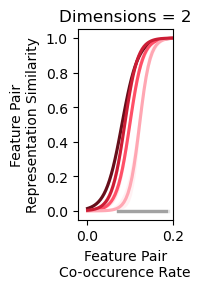

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))


for depth in comp_rep_similarity['depth'].unique():

    idx = (
        (comp_rep_similarity['depth'] == depth) &
        (comp_rep_similarity['model_label'] == 'ff-biased')
        )
    sns.regplot(
        data = comp_rep_similarity.loc[idx],
        x = 'rate_composition',
        y = 'r',
        color = DEPTH_PALETTE_BW[depth - 1],
        scatter = False,
        label = f'Depth {depth}',
        logistic = True,
        ax = ax,
    )

    idx = (
        (comp_rep_similarity['depth'] == depth) &
        (comp_rep_similarity['model_label'] == 'ff')
        )
    sns.regplot(
        data = comp_rep_similarity.loc[idx],
        x = 'rate_composition',
        y = 'r',
        color = DEPTH_PALETTE_DIM2[depth - 1],
        scatter = False,
        label = f'Depth {depth}',
        logistic = True,
        ax = ax,
    )
#ax.legend()
ax.set_xlim(None, .2)
ax.set_xlabel('Feature Pair\nCo-occurence Rate')
ax.set_ylabel('Feature Pair\nRepresentation Similarity')
ax.set_title('Dimensions = 2')
set_axis_ratio(ax, 2)
plt.tight_layout()
fig.savefig(f'{FIG_PATH}/similarity-by-rate.pdf')


/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_72407/1671792656.py:2: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_72407/1671792656.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)


[Text(0, 0, '[5 0 6 0]'),
 Text(1, 0, '[0 5 6 0]'),
 Text(2, 0, '[6 0 6 0]'),
 Text(3, 0, '[0 6 6 0]'),
 Text(4, 0, '[5 0 0 6]'),
 Text(5, 0, '[0 5 0 6]'),
 Text(6, 0, '[6 0 0 6]'),
 Text(7, 0, '[0 6 0 6]'),
 Text(8, 0, '[5 0 0 5]'),
 Text(9, 0, '[0 5 0 5]'),
 Text(10, 0, '[6 0 0 5]'),
 Text(11, 0, '[5 0 5 0]'),
 Text(12, 0, '[0 5 5 0]'),
 Text(13, 0, '[0 6 0 5]'),
 Text(14, 0, '[6 0 5 0]'),
 Text(15, 0, '[0 6 5 0]'),
 Text(16, 0, '[0 4 4 0]'),
 Text(17, 0, '[5 0 4 0]'),
 Text(18, 0, '[0 4 0 5]'),
 Text(19, 0, '[4 0 4 0]'),
 Text(20, 0, '[0 5 4 0]'),
 Text(21, 0, '[4 0 0 5]'),
 Text(22, 0, '[0 4 0 4]'),
 Text(23, 0, '[0 4 5 0]'),
 Text(24, 0, '[5 0 0 4]'),
 Text(25, 0, '[4 0 0 4]'),
 Text(26, 0, '[0 5 0 4]'),
 Text(27, 0, '[4 0 5 0]'),
 Text(28, 0, '[3 0 0 4]'),
 Text(29, 0, '[3 0 3 0]'),
 Text(30, 0, '[0 4 3 0]'),
 Text(31, 0, '[4 0 3 0]'),
 Text(32, 0, '[3 0 4 0]'),
 Text(33, 0, '[0 4 0 3]'),
 Text(34, 0, '[0 3 3 0]'),
 Text(35, 0, '[3 0 0 3]'),
 Text(36, 0, '[4 0 0 3]'),
 Text(37, 0

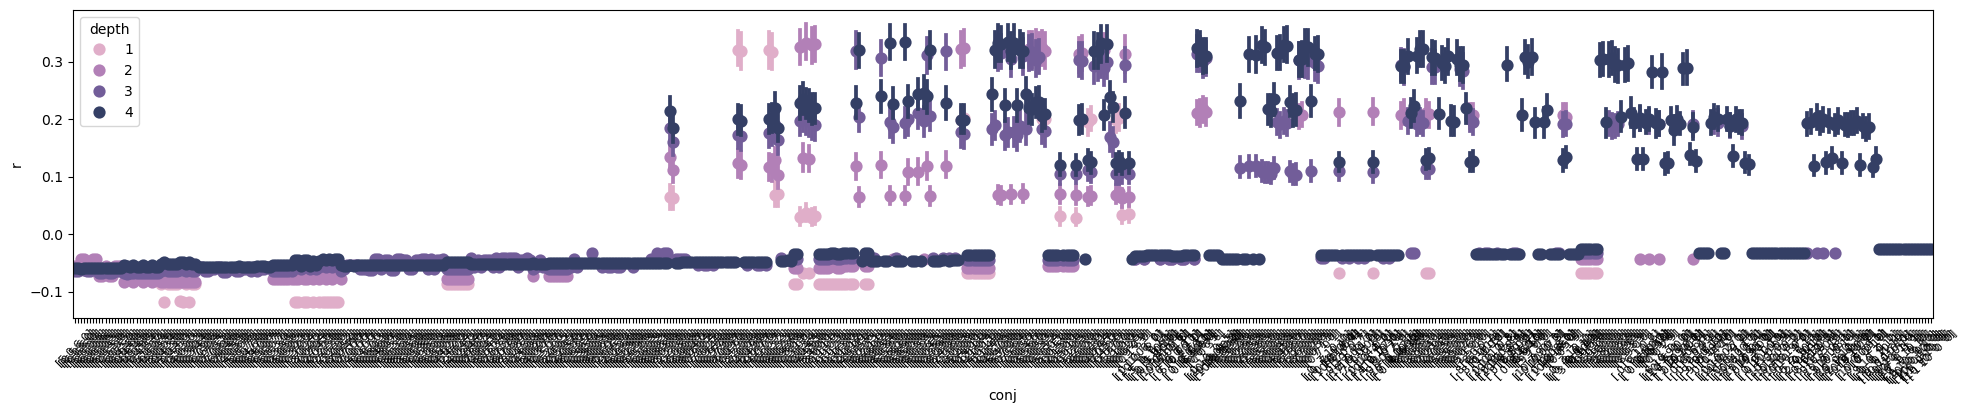

In [ ]:
conj_rep_similarity = conj_rep_similarity.sort_values(by = 'r')
fig, ax = plt.subplots(figsize=(24, 4))
sns.pointplot(
    data = conj_rep_similarity,
    x = 'conj',
    y = 'r',
    hue = 'depth',
    palette = DEPTH_PALETTE,
    join = False,
    ax = ax
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)

### Get mean representation by environment & model

In [19]:
mean_representations = {}
counts = {}
for key in representations.keys():

    if key[:-1] not in mean_representations.keys():
        mean_representations[key[:-1]] = representations[key]
        counts[key[:-1]] = 1
    else:
        try:
            mean_representations[key[:-1]] += representations[key]
            counts[key[:-1]] += 1
        except:
            print(f'Wrong shape for {key}')
    
for key in mean_representations.keys():
    mean_representations[key] /= counts[key]


Wrong shape for (2, 1, 'ff', 250)
Wrong shape for (1, 4, 'ff', 242)
Wrong shape for (1, 4, 'ff', 241)
Wrong shape for (1, 4, 'ff', 190)
Wrong shape for (1, 4, 'ff', 170)
Wrong shape for (1, 4, 'ff', 210)
Wrong shape for (1, 2, 'ff', 121)
Wrong shape for (1, 2, 'ff', 64)
Wrong shape for (1, 2, 'ff', 150)
Wrong shape for (1, 2, 'ff', 224)
Wrong shape for (1, 2, 'ff', 228)
Wrong shape for (1, 2, 'ff', 21)
Wrong shape for (1, 2, 'ff', 239)
Wrong shape for (1, 2, 'ff', 33)
Wrong shape for (1, 1, 'ff', 134)
Wrong shape for (1, 1, 'ff', 121)
Wrong shape for (1, 1, 'ff', 88)
Wrong shape for (1, 1, 'ff', 250)
Wrong shape for (1, 1, 'ff', 133)
Wrong shape for (1, 1, 'ff', 119)
Wrong shape for (1, 1, 'ff', 247)
Wrong shape for (1, 1, 'ff', 209)
Wrong shape for (1, 1, 'ff', 169)
Wrong shape for (1, 1, 'ff', 10)
Wrong shape for (1, 1, 'ff', 38)
Wrong shape for (1, 1, 'ff', 150)
Wrong shape for (1, 1, 'ff', 146)
Wrong shape for (1, 1, 'ff', 219)
Wrong shape for (1, 1, 'ff', 225)
Wrong shape for (1, 

In [43]:
all_corr_matrices = {}
for key in mean_representations.keys():
    corr_matrix = np.zeros(np.shape(mean_representations[key]))
    for i in range(len(mean_representations[key])):
        for j in range(len(mean_representations[key])):
            corr_matrix[i, j] = np.corrcoef(
                mean_representations[key][i],
                mean_representations[key][j]
            )[0, 1]
    all_corr_matrices[key] = corr_matrix



NameError: name 'mean_representations' is not defined

In [13]:
depth_levels = np.sort(test_summary['depth'].unique())

rsm_correlations = []
rsm_diffs = []
all_sims = []

for depth in depth_levels:
    for subj in np.unique(subj_df['id']):

        # Compute unbiased and biased RSMs
        rsms = {}
        for model in ['ff', 'ff-biased']:
            key = (2, depth, model, subj)
            rsm = np.zeros(np.shape(representations[key]))
            for i in range(len(representations[key])):
                for j in range(len(representations[key])):
                    rsm[i, j] = np.corrcoef(
                        representations[key][i],
                        representations[key][j]
                    )[0, 1]
            rsms[model] = rsm

        # Compute correlation between RSMS
        try:
            corr = np.corrcoef(
                rsms['ff'].flatten(),
                rsms['ff-biased'].flatten()
            )[0, 1]
        except:
            print(f'Error for {depth}, {subj}')
            continue

        rsm_correlations = rsm_correlations + [{
            'depth': depth,
            'id': subj,
            'corr': corr
        }]

        # Save similarities
        for model in ['ff', 'ff-biased']:
            all_sims.append(
                pd.DataFrame({
                    'depth': depth,
                    'id': subj,
                    'model': model,
                    'r': rsms[model].flatten()
                })
            )

        # Compute difference between RSMS in true and incidental 
        # regions 
        rsm_diff = rsms['ff'] - rsms['ff-biased']

        #true_mask = create_mask(len(rsm_diff))
        #inci_mask = (1 - true_mask - np.eye(len(true_mask)))

        key_biased = (2, depth, 'ff-biased', subj)
        true_mask = np.ceil(representations[key_biased]/np.max(representations[key_biased]))
        true_mask -= np.eye(len(true_mask))
        inci_mask = (1 - true_mask - np.eye(len(true_mask)))
        half_mask = create_mask(len(rsm_diff), 2)
        inci_mask = inci_mask*half_mask




        true_sum_diff = np.sum(rsm_diff*true_mask)/np.sum(rsm_diff)
        inci_sum_diff = np.sum(rsm_diff*inci_mask)/np.sum(rsm_diff)
        rsm_diffs.append({
            'depth': depth,
            'id': subj,
            'true': true_sum_diff,
            'incidental': inci_sum_diff
        })


rsm_correlations = pd.DataFrame(rsm_correlations)
rsm_diffs = pd.DataFrame(rsm_diffs)
rsm_diffs = pd.melt(
    rsm_diffs,
    id_vars = ['depth', 'id'],
    value_vars = ['true', 'incidental'],
    var_name = 'transition',
    value_name = 'sum_diff'
)
all_sims = pd.concat(all_sims)

Error for 1, 250


In [21]:
depth_levels = np.sort(test_summary['depth'].unique())

rep_correlations = []
rep_correlations_to_terminal = []
rep_mass = []
rep_diffs = []
rep_entropy = []
all_sims = []

for depth in depth_levels:
    for subj in np.unique(subj_df['id']):

        M = representations[(2, depth, 'ff', subj)]
        M_biased = representations[(2, depth, 'ff-biased', subj)]
        try:
            M_diff = M - M_biased
        except:
            pass

        true_mask = np.ceil(M_biased/np.max(M_biased))
        true_mask -= np.eye(len(true_mask))

        inci_mask = (1 - true_mask - np.eye(len(true_mask)))
        #half_mask = create_mask(len(M_diff), 2)
        #inci_mask = inci_mask*half_mask

        non_eye_mask = np.logical_not(np.eye(len(M_biased))).astype(int)

        # Compute correlation between RSMS
        steps_from_terminal = np.tile(
            [*range(depth + 1), *range(depth + 1)[::-1]],
            4
        )
        
        try:
            for steps in range(1, depth + 1):
                idx = steps_from_terminal == steps
                corr = np.corrcoef(
                    M[idx].flatten(),
                    M_biased[idx].flatten()
                )[0, 1]
                rep_correlations = rep_correlations + [{
                    'depth': depth,
                    'id': subj,
                    'steps_from_terminal': steps,
                    'corr': corr
                }]

                """rep_entropy.append({
                    'depth': depth,
                    'id': subj,
                    'model': 'ff',
                    'steps_from_terminal': steps,
                    'mean_entropy': np.mean(entropy(M[idx], axis=1))
                })

                rep_entropy.append({
                    'depth': depth,
                    'id': subj,
                    'model': 'ff-biased',
                    'steps_from_terminal': steps,
                    'mean_entropy': np.mean(entropy(M_biased[idx], axis=1))
                })"""
                rep_entropy.append({
                    'depth': depth,
                    'id': subj,
                    'steps_from_terminal': steps,
                    'mean_entropy_diff': np.mean(entropy(M[idx], axis=1) - entropy(M_biased[idx], axis=1))
                })


                idx_terminal = steps_from_terminal == 0
                corr_ff = np.corrcoef(
                    M[idx].flatten(),
                    M[idx_terminal].flatten()
                )[0, 1]
                """rep_correlations_to_terminal = rep_correlations_to_terminal + [{
                    'depth': depth,
                    'id': subj,
                    'model': 'ff',
                    'steps_from_terminal': steps,
                    'corr': corr
                }]"""

                corr_biased = np.corrcoef(
                    M_biased[idx].flatten(),
                    M_biased[idx_terminal].flatten()
                )[0, 1]
                """rep_correlations_to_terminal = rep_correlations_to_terminal + [{
                    'depth': depth,
                    'id': subj,
                    'model': 'ff-biased',
                    'steps_from_terminal': steps,
                    'corr': corr
                }]"""
                rep_correlations_to_terminal = rep_correlations_to_terminal + [{
                    'depth': depth,
                    'id': subj,
                    'steps_from_terminal': steps,
                    'corr_diff': corr - corr_biased
                }]



                

                

                
                p_inci = np.mean(np.sum(M[idx]*inci_mask[idx], axis=1)/np.sum(M[idx]*non_eye_mask[idx], axis=1))
                rep_mass.append({
                    'depth': depth,
                    'id': subj,
                    'steps_from_terminal': steps,
                    'p_inci': p_inci
                })
              
                
                """true_sum_diff = np.sum(M_diff[idx]*true_mask[idx])/np.sum(M_diff[idx]*non_eye_mask[idx])
                inci_sum_diff = np.sum(M_diff[idx]*inci_mask[idx])/np.sum(M_diff[idx]*non_eye_mask[idx])

                rep_mass.append({
                    'depth': depth,
                    'id': subj,
                    'steps_from_terminal': steps,
                    'transition': 'true',
                    'mass_diff': true_sum_diff
                })

                rep_mass.append({
                    'depth': depth,
                    'id': subj,
                    'steps_from_terminal': steps,
                    'transition': 'incidental',
                    'mass_diff': inci_sum_diff
                })"""



        except:
            print(f'Error for {depth}, {subj}')
            continue
        """try:
            corr = np.corrcoef(
                M.flatten(),
                M_biased.flatten()
            )[0, 1]
        except:
            print(f'Error for {depth}, {subj}')
            continue

        rep_correlations = rep_correlations + [{
            'depth': depth,
            'id': subj,
            'corr': corr
        }]"""


        # Compute difference between RSMS in true and incidental 
        # regions 
        M_diff = M - M_biased

        #true_mask = create_mask(len(rsm_diff))
        #inci_mask = (1 - true_mask - np.eye(len(true_mask)))

        true_mask = np.ceil(M_biased/np.max(M_biased))
        true_mask -= np.eye(len(true_mask))

        inci_mask = (1 - true_mask - np.eye(len(true_mask)))
        half_mask = create_mask(len(M_diff), 2)
        inci_mask = inci_mask*half_mask


        true_sum_diff = np.sum(M_diff*true_mask)/np.sum(M_diff)
        inci_sum_diff = np.sum(M_diff*inci_mask)/np.sum(M_diff)

        """
        rep_diffs.append({
            'depth': depth,
            'id': subj,
            'transition': 'true',
            'relative_mass': true_sum_diff#np.mean(np.sum(M_diff*true_mask, axis=1))
        })

        rep_diffs.append({
            'depth': depth,
            'id': subj,
            'transition': 'incidental',
            'relative_mass': inci_sum_diff#np.mean(np.sum(M_diff*inci_mask, axis=1))
        })

        rep_diffs.append({
            'depth': depth,
            'id': subj,
            'true': true_sum_diff,
            'incidental': inci_sum_diff
        })"""
        non_eye_mask = np.logical_not(np.eye(len(M_diff))).astype(int)
        rep_diffs.append({
            'depth': depth,
            'id': subj,
            'model': 'ff',
            'transition': 'true',
            'mass': np.mean(np.sum(M*true_mask/np.sum(M*non_eye_mask), axis=1))
        })

        rep_diffs.append({
            'depth': depth,
            'id': subj,
            'model': 'ff',
            'transition': 'incidental',
            'mass': np.mean(np.sum(M*inci_mask/np.sum(M*non_eye_mask), axis=1))
        })

        rep_diffs.append({
            'depth': depth,
            'id': subj,
            'model': 'ff-biased',
            'transition': 'true',
            'mass': np.mean(np.sum(M_biased*true_mask/np.sum(M_biased*non_eye_mask), axis=1))
        })

        rep_diffs.append({
            'depth': depth,
            'id': subj,
            'model': 'ff-biased',
            'transition': 'incidental',
            'mass': np.mean(np.sum(M_biased*inci_mask/np.sum(M_biased*non_eye_mask), axis=1))
        })

        
        """rep_entropy.append({
            'depth': depth,
            'id': subj,
            'model': 'ff',
            'mean_entropy': np.mean(entropy(M, axis=1))
        })

        rep_entropy.append({
            'depth': depth,
            'id': subj,
            'model': 'ff-biased',
            'mean_entropy': np.mean(entropy(M_biased, axis=1))
        })"""
        """
        rep_entropy.append({
            'depth': depth,
            'id': subj,
            'mean_entropy': np.mean(entropy(M, axis=1) - entropy(M_biased, axis=1))
        })
        """


rep_correlations = pd.DataFrame(rep_correlations)


rep_correlations_to_terminal = pd.DataFrame(rep_correlations_to_terminal)
rep_diffs = pd.DataFrame(rep_diffs)
rep_mass = pd.DataFrame(rep_mass)
"""rep_diffs = pd.melt(
    rep_diffs,
    id_vars = ['depth', 'id'],
    value_vars = ['true', 'incidental'],
    var_name = 'transition',
    value_name = 'sum_diff'
)"""
rep_entropy = pd.DataFrame(rep_entropy)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_80893/1706616554.py:174: RuntimeWarning: divide by zero encountered in scalar divide
  true_sum_diff = np.sum(M_diff*true_mask)/np.sum(M_diff)
/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_80893/1706616554.py:175: RuntimeWarning: divide by zero encountered in scalar divide
  inci_sum_diff = np.sum(M_diff*inci_mask)/np.sum(M_diff)
/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_80893/1706616554.py:110: RuntimeWarning: invalid value encountered in divide
  p_inci = np.mean(np.sum(M[idx]*inci_mask[idx], axis=1)/np.sum(M[idx]*non_eye_mask[idx], axis=1))


Error for 1, 250


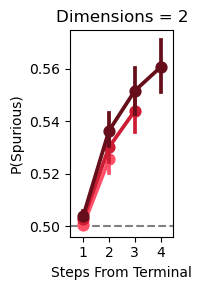

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.axhline(.5, color='.5', ls='--')
sns.pointplot(
    data = rep_mass,
    x = 'steps_from_terminal',
    y = 'p_inci',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    #dodge = .2
)
ax.get_legend().remove()
ax.set_xlabel('Steps From Terminal')
ax.set_ylabel('P(Spurious)')
ax.set_title('Dimensions = 2')
set_axis_ratio(ax, 2)
plt.tight_layout()
fig.savefig(f'{FIG_PATH}/p-spurious-mass.pdf')

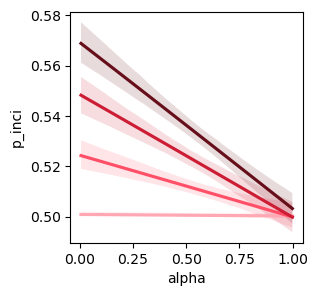

In [23]:
idx = subj_df['model_label'] == 'ff'
rep_mass_alpha = pd.merge(
    rep_mass,
    subj_df.loc[idx, ['id', 'alpha']],
    on = 'id',
    how = 'left'
)
rep_mass_alpha = rep_mass_alpha.dropna()
rep_mass_alpha = rep_mass_alpha.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(3, 3))
for depth in rep_mass_alpha['depth'].unique():

    idx = rep_mass_alpha['depth'] == depth
    sns.regplot(
        data = rep_mass_alpha.loc[idx],
        x = 'alpha',
        y = 'p_inci',
        color = DEPTH_PALETTE_DIM2[depth - 1],
        scatter = False,
        label = f'Depth {depth}',
        logistic = True,
        ax = ax
    )


<Axes: xlabel='alpha_bin', ylabel='p_inci'>

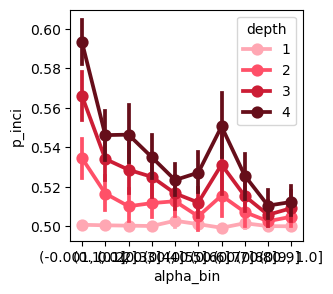

In [25]:
idx = subj_df['model_label'] == 'ff'
rep_mass_alpha = pd.merge(
    rep_mass,
    subj_df.loc[idx, ['id', 'alpha']],
    on = 'id',
    how = 'left'
)
rep_mass_alpha = rep_mass_alpha.dropna()
rep_mass_alpha = rep_mass_alpha.reset_index(drop=True)
# Bin alpha values
rep_mass_alpha['alpha_bin'] = pd.cut(
    rep_mass_alpha['alpha'],
    bins = np.arange(0, 1.1, .1),
    include_lowest = True
)

fig, ax = plt.subplots(figsize=(3, 3))
sns.pointplot(
    data = rep_mass_alpha,
    x = 'alpha_bin',
    y = 'p_inci',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    ax = ax
)

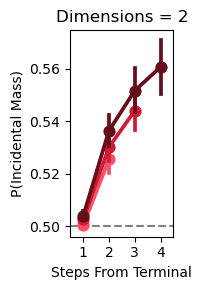

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.axhline(.5, color='.5', ls='--')
sns.pointplot(
    data = rep_mass,
    x = 'steps_from_terminal',
    y = 'p_inci',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    #dodge = .2
)
ax.get_legend().remove()
ax.set_xlabel('Steps From Terminal')
ax.set_ylabel('P(Incidental Mass)')
ax.set_title('Dimensions = 2')
set_axis_ratio(ax, 2)
plt.tight_layout()
#fig.savefig(f'{FIG_PATH}/sr-correlations.pdf')

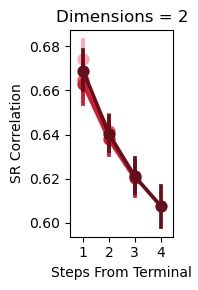

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.pointplot(
    data = rep_correlations,
    x = 'steps_from_terminal',
    y = 'corr',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
   # dodge = .2
)
ax.get_legend().remove()
ax.set_xlabel('Steps From Terminal')
ax.set_ylabel('SR Correlation')
ax.set_title('Dimensions = 2')
set_axis_ratio(ax, 2)
plt.tight_layout()
#fig.savefig(f'{FIG_PATH}/sr-correlations.pdf')

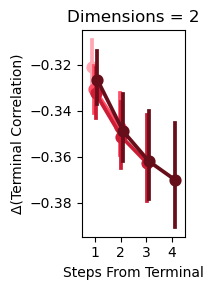

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.pointplot(
    data = rep_correlations_to_terminal,
    x = 'steps_from_terminal',
    y = 'corr_diff',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    dodge = .2
)
ax.get_legend().remove()
ax.set_xlabel('Steps From Terminal')
ax.set_ylabel('Δ(Terminal Correlation)')
ax.set_title('Dimensions = 2')
set_axis_ratio(ax, 2)
plt.tight_layout()
#fig.savefig(f'{FIG_PATH}/sr-correlations.pdf')

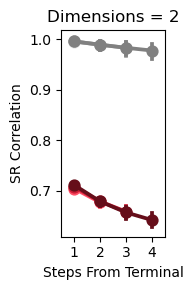

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

idx = rep_correlations_to_terminal['model'] == 'ff-biased'
sns.pointplot(
    data = rep_correlations_to_terminal.loc[idx],
    x = 'steps_from_terminal',
    y = 'corr',
    hue = 'depth',
    palette = DEPTH_PALETTE_BW,
)

idx = rep_correlations_to_terminal['model'] == 'ff'
sns.pointplot(
    data = rep_correlations_to_terminal.loc[idx],
    x = 'steps_from_terminal',
    y = 'corr',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
)
ax.get_legend().remove()
ax.set_xlabel('Steps From Terminal')
ax.set_ylabel('SR Correlation')
ax.set_title('Dimensions = 2')
set_axis_ratio(ax, 2)
plt.tight_layout()
#fig.savefig(f'{FIG_PATH}/sr-correlations.pdf')

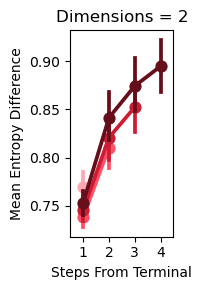

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

sns.pointplot(
    data = rep_entropy,
    x = 'steps_from_terminal',
    y = 'mean_entropy_diff',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    #dodge = .2
)

ax.get_legend().remove()
ax.set_xlabel('Steps From Terminal')
ax.set_ylabel('Mean Entropy Difference')
ax.set_title('Dimensions = 2')
set_axis_ratio(ax, 2)
plt.tight_layout()
#fig.savefig(f'{FIG_PATH}/sr-correlations.pdf')

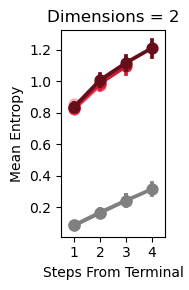

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

idx = rep_entropy['model'] == 'ff-biased'
sns.pointplot(
    data = rep_entropy.loc[idx],
    x = 'steps_from_terminal',
    y = 'mean_entropy',
    hue = 'depth',
    palette = DEPTH_PALETTE_BW,
)


idx = rep_entropy['model'] == 'ff'
sns.pointplot(
    data = rep_entropy.loc[idx],
    x = 'steps_from_terminal',
    y = 'mean_entropy',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
)

ax.get_legend().remove()
ax.set_xlabel('Steps From Terminal')
ax.set_ylabel('Mean Entropy')
ax.set_title('Dimensions = 2')
set_axis_ratio(ax, 2)
plt.tight_layout()
#fig.savefig(f'{FIG_PATH}/sr-correlations.pdf')

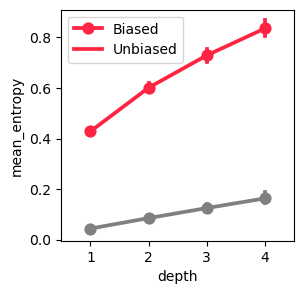

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.pointplot(
    data = rep_entropy,
    x = 'depth',
    y = 'mean_entropy',
    hue = 'model',
    palette = LABEL_PALETTE
)
ax.legend(['Biased', 'Unbiased'])

ValueError: Could not interpret value `relative_mass` for `y`. An entry with this name does not appear in `data`.

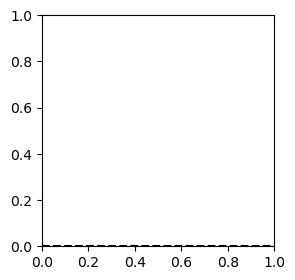

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.axhline(0, color='black', linestyle='--')
sns.pointplot(
    data = rep_diffs,
    x = 'depth',
    y = 'relative_mass',
    hue = 'transition'
    #palette = LABEL_PALETTE
)
#ax.legend(['Biased', 'Unbiased'])

<Axes: xlabel='depth', ylabel='mass'>

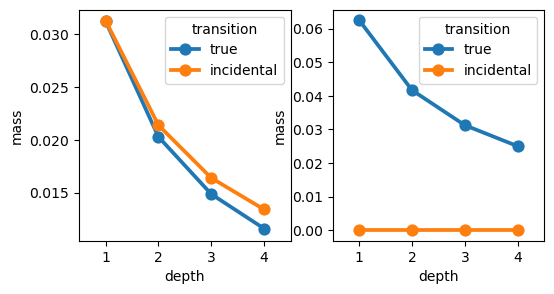

In [65]:

fig, axs = plt.subplots(1, 2, figsize=(6, 3))

idx = rep_diffs['model'] == 'ff'
sns.pointplot(
    data = rep_diffs.loc[idx],
    x = 'depth',
    y = 'mass',
    hue = 'transition',
    #palette = LABEL_PALETTE,
    ax = axs[0],
)

idx = rep_diffs['model'] == 'ff-biased'
sns.pointplot(
    data = rep_diffs.loc[idx],
    x = 'depth',
    y = 'mass',
    hue = 'transition',
    #palette = LABEL_PALETTE,
    ax = axs[1],
)

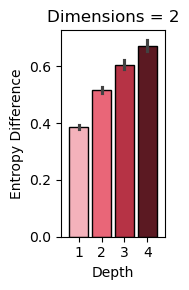

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 3))
sns.barplot(
    data = rep_entropy,
    x = 'depth',
    y = 'mean_entropy',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    edgecolor = 'black',
    ax = ax
)


ax.get_legend().remove()
ax.set_xlim(-.75, 3.75)
#ax.set_ylim(.35, None)
ax.set_xlabel('Depth')
ax.set_ylabel('Entropy Difference')
ax.set_title('Dimensions = 2')
set_axis_ratio(ax, 2)
plt.tight_layout()
#fig.savefig(f'{FIG_PATH}/sr-correlations.pdf')

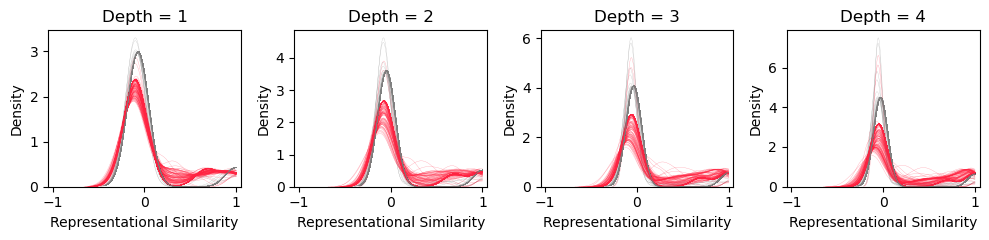

In [ ]:
n_subplots = len(depth_levels)
fig, axs = plt.subplots(1, n_subplots, figsize=(2.5*n_subplots, 2.5))

for i, depth in enumerate(depth_levels):
    ax = axs[i]
    for j in range(len(all_sims[depth]['ff'])):
        sns.kdeplot(
            all_sims[depth]['ff'][j],
            color=LABEL_PALETTE['dim2_ff'],
            alpha=.5,
            clip=[-1, 1],
            linewidth=.2,
            ax=ax
        )
        sns.kdeplot(
            all_sims[depth]['ff-biased'][j],
            color=LABEL_PALETTE['dim2_ff-biased'],
            alpha=.5,
            clip=[-1, 1],
            linewidth=.2,
            ax=ax
        )

    ax.set_xlim(-1.05, 1.05)
    ax.set_xlabel('Representational Similarity')
    ax.set_title(f'Depth = {depth}')
    #set_axis_ratio(ax)
fig.tight_layout()
fig.savefig(f'{FIG_PATH}/representational-similarity-density.pdf')

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_60391/4076870332.py:8: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.kdeplot(
/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_60391/4076870332.py:8: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.kdeplot(


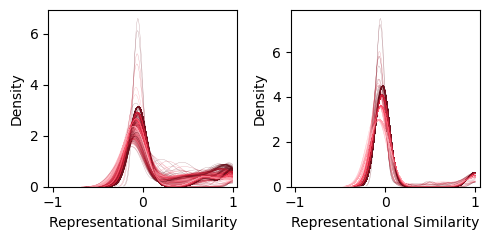

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

for i, model in enumerate(['ff', 'ff-biased']):
    ax = axs[i]
    model_sims = all_sims.loc[all_sims['model'] == model]
    for subj in np.unique(model_sims['id']):
        idx = model_sims['id'] == subj
        sns.kdeplot(
            model_sims.loc[idx],
            x = 'r',
            hue = 'depth',
            palette = DEPTH_PALETTE_DIM2,
            common_norm=False,
            #color=LABEL_PALETTE['dim2_ff'],
            alpha=.5,
            clip=[-1, 1],
            linewidth=.2,
            ax=ax
        )
    ax.get_legend().remove()
    ax.set_xlim(-1.05, 1.05)
    ax.set_xlabel('Representational Similarity')
    #set_axis_ratio(ax)
fig.tight_layout()
fig.savefig(f'{FIG_PATH}/representational-similarity-density.pdf')

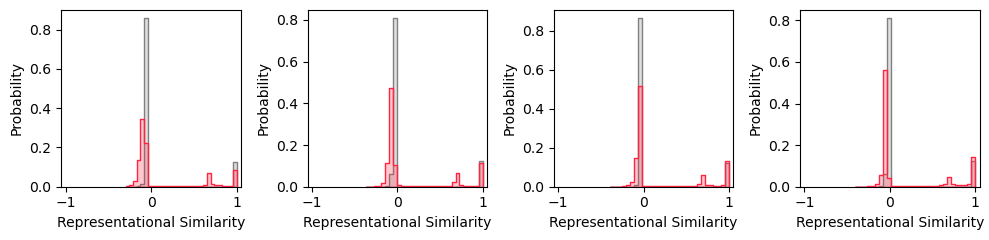

In [82]:
n_subplots = len(depth_levels)
fig, axs = plt.subplots(1, n_subplots, figsize=(2.5*n_subplots, 2.5))

for i, depth in enumerate(depth_levels):
    ax = axs[i]
    idx = all_sims['depth'] == depth
    sns.histplot(
        all_sims.loc[idx],
        x = 'r',
        hue = 'model',
        palette = [LABEL_PALETTE['dim2_ff'], LABEL_PALETTE['dim2_ff-biased']],
        stat = "probability",
        element = 'step',
        common_norm=False,
        bins = 30,
        ax = ax
    )
    ax.get_legend().remove()
    ax.set_xlim(-1.05, 1.05)
    ax.set_xlabel('Representational Similarity')
    #set_axis_ratio(ax)
fig.tight_layout()
fig.savefig(f'{FIG_PATH}/representational-similarity-density.pdf')

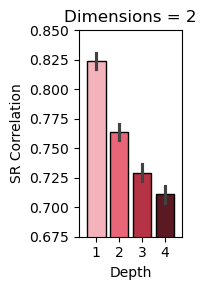

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 3))
sns.barplot(
    data = rep_correlations,
    x = 'depth',
    y = 'corr',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    edgecolor = 'k',
    ax = ax
)
ax.get_legend().remove()
ax.set_xlim(-.75, 3.75)
ax.set_ylim(.675, .85)
ax.set_xlabel('Depth')
ax.set_ylabel('SR Correlation')
ax.set_title('Dimensions = 2')
set_axis_ratio(ax, 2)
plt.tight_layout()
fig.savefig(f'{FIG_PATH}/sr-correlations.pdf')


/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_44305/2178062299.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Inci.', 'True'])


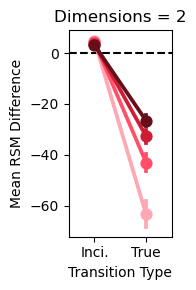

In [16]:
fig, ax = plt.subplots(figsize=(2.5, 3))
ax.axhline(0, color='k', linestyle='--')
sns.pointplot(
    data = rep_diffs,
    x = 'transition',
    y = 'sum_diff',
    order = ['incidental', 'true'],
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    ax = ax
)
ax.get_legend().remove()
ax.set_xticklabels(['Inci.', 'True'])
ax.set_xlabel('Transition Type')
ax.set_ylabel('Mean RSM Difference')
ax.set_title('Dimensions = 2')
set_axis_ratio(ax, 2)
plt.tight_layout()
#fig.savefig(f'{FIG_PATH}/rsm-differences.pdf')

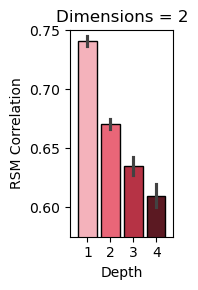

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 3))
sns.barplot(
    data = rsm_correlations,
    x = 'depth',
    y = 'corr',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    edgecolor = 'k',
    ax = ax
)
ax.get_legend().remove()
ax.set_xlim(-.75, 3.75)
ax.set_ylim(.575, .75)
ax.set_xlabel('Depth')
ax.set_ylabel('RSM Correlation')
ax.set_title('Dimensions = 2')
set_axis_ratio(ax, 2)
plt.tight_layout()
fig.savefig(f'{FIG_PATH}/rsm-correlations.pdf')


/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_29015/3025754531.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Inci.', 'True'])


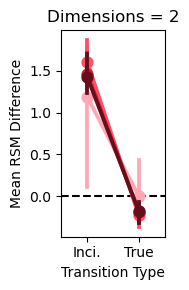

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 3))
ax.axhline(0, color='k', linestyle='--')
sns.pointplot(
    data = rsm_diffs,
    x = 'transition',
    y = 'sum_diff',
    order = ['incidental', 'true'],
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    ax = ax
)
ax.get_legend().remove()
ax.set_xticklabels(['Inci.', 'True'])
ax.set_xlabel('Transition Type')
ax.set_ylabel('Mean RSM Difference')
ax.set_title('Dimensions = 2')
set_axis_ratio(ax, 2)
plt.tight_layout()
fig.savefig(f'{FIG_PATH}/rsm-differences.pdf')

Depth: 1 True: 0.02231356294350243 Incidental: 0.11571759814622479
Depth: 2 True: 0.02725166384194792 Incidental: 0.14206371016655767
Depth: 3 True: 0.033924082520472104 Incidental: 0.15661614307879704
Depth: 4 True: 0.04052995544038256 Incidental: 0.16611714285710094


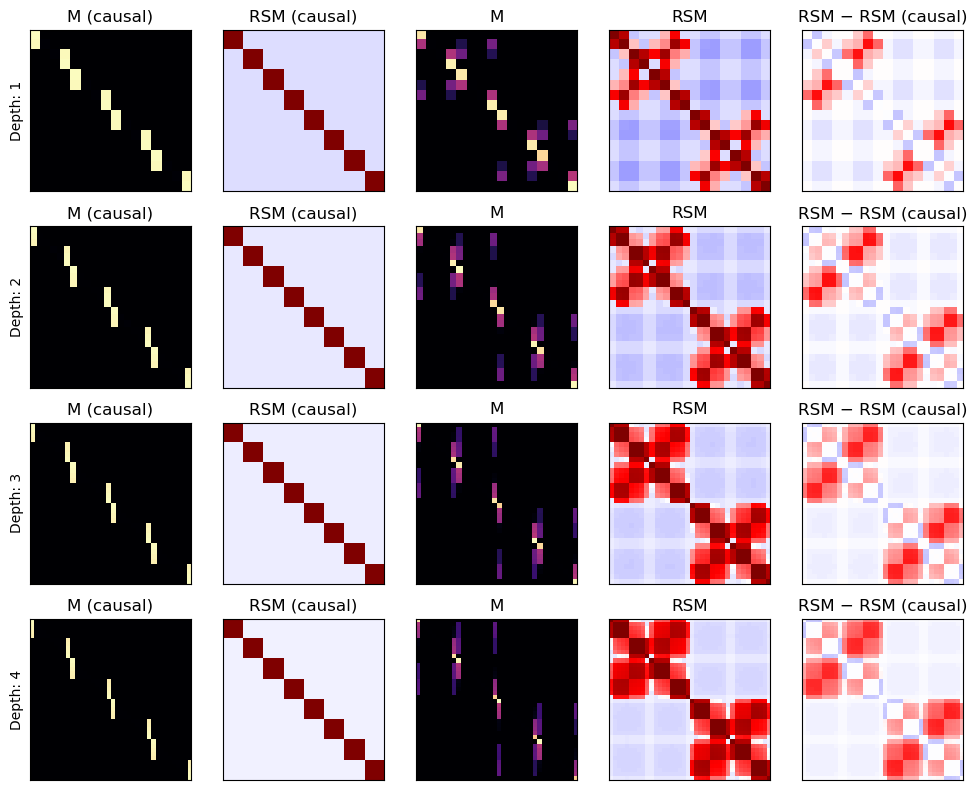

In [22]:
depth_levels = np.sort(test_summary['depth'].unique())
n_subplots = len(depth_levels)
fig, axs = plt.subplots(n_subplots, 5, figsize=(10, 2*n_subplots))

diff_sums = []
for i, depth in enumerate(depth_levels):

    key_biased = (2, depth, 'ff-biased')
    key = (2, depth, 'ff')

    # Plot biased representations
    ax = axs[i, 0]
    ax.imshow(mean_representations[key_biased], cmap='magma')
    ax.set_title(f'M (causal)')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(f'Depth: {depth}')
    ax = axs[i, 1]
    ax.imshow(all_corr_matrices[key_biased], cmap='seismic', vmin=-1, vmax=1)
    ax.set_title(f'RSM (causal)')
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot unbiased representations
    ax = axs[i, 2]
    ax.imshow(mean_representations[key], cmap='magma')
    ax.set_title(f'M')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = axs[i, 3]
    ax.imshow(all_corr_matrices[key], cmap='seismic', vmin=-1, vmax=1)
    ax.set_title(f'RSM')
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot difference
    ax = axs[i, 4]
    rdm_diff = all_corr_matrices[key] - all_corr_matrices[key_biased]
    ax.imshow(rdm_diff, cmap='seismic', vmin=-2, vmax=2)
    ax.set_title(f'RSM − RSM (causal)')
    ax.set_xticks([])
    ax.set_yticks([])

    true_mask = create_mask(len(rdm_diff))
    inci_mask = (1 - true_mask - np.eye(len(true_mask)))
    true_sum_diff = np.mean(np.abs(rdm_diff*true_mask))
    inci_sum_diff = np.mean(np.abs(rdm_diff*inci_mask))
    print(f'Depth: {depth} True: {true_sum_diff} Incidental: {inci_sum_diff}')
    diff_sums.append({
        'depth': depth,
        'true': true_sum_diff,
        'incidental': inci_sum_diff
    })

diff_sums = pd.DataFrame(diff_sums)
diff_sums = pd.melt(diff_sums, id_vars='depth', var_name='transition', value_name='sum_corr_diff')

fig.tight_layout()
fig.savefig(f'{FIG_PATH}/representations.pdf')

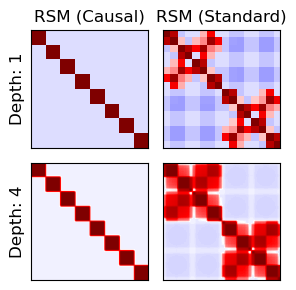

In [67]:
cmap = 'seismic'#sns.diverging_palette(0, 200, s=100, as_cmap=True)

depth_levels = [1, 4]
n_subplots = len(depth_levels)
fig, axs = plt.subplots(n_subplots, 2, figsize=(3, 1.5*n_subplots))

diff_sums = []
for i, depth in enumerate(depth_levels):

    key_biased = (2, depth, 'ff-biased')
    key = (2, depth, 'ff')

    # Plot biased representations
    ax = axs[i, 0]
    ax.imshow(all_corr_matrices[key_biased], cmap=cmap, vmin=-1, vmax=1)
    if depth == 1:
        ax.set_title('RSM (Causal)')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(f'Depth: {depth}', fontsize=12)

    # Plot unbiased representations
    ax = axs[i, 1]
    ax.imshow(all_corr_matrices[key], cmap=cmap, vmin=-1, vmax=1)
    if depth == 1:
        ax.set_title('RSM (Standard)')
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
fig.savefig(f'{FIG_PATH}/rsm.pdf', dpi=300)

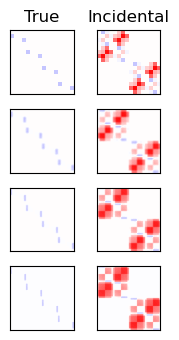

In [ ]:
depth_levels = np.sort(test_summary['depth'].unique())
n_subplots = len(depth_levels)
fig, axs = plt.subplots(n_subplots, 2, figsize=(2, 3.5))

diff_sums = []
for i, depth in enumerate(depth_levels):

    key_biased = (2, depth, 'ff-biased')
    key = (2, depth, 'ff')


    # Plot difference
    rdm_diff = all_corr_matrices[key] - all_corr_matrices[key_biased]
    true_mask = np.ceil(mean_representations[key_biased]/np.max(mean_representations[key_biased]))
    true_mask -= np.eye(len(true_mask))
    inci_mask = (1 - true_mask - np.eye(len(true_mask)))

    #true_mask = create_mask(len(rdm_diff))
    #inci_mask = (1 - true_mask - np.eye(len(true_mask)))
    half_mask = create_mask(len(rdm_diff), 2)
    inci_mask = inci_mask*half_mask

    ax = axs[i, 0]
    ax.imshow(rdm_diff*true_mask, cmap='seismic', vmin=-2, vmax=2)
    ax.set_xticks([])
    ax.set_yticks([])
    if depth == 1:
        ax.set_title('True')

    ax = axs[i, 1]
    ax.imshow(rdm_diff*inci_mask, cmap='seismic', vmin=-2, vmax=2)
    ax.set_xticks([])
    ax.set_yticks([])
    if depth == 1:
        ax.set_title('Incidental')

fig.tight_layout()
fig.savefig(f'{FIG_PATH}/representation-diffs.pdf')

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_40547/3720940362.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Incidental', 'True'])


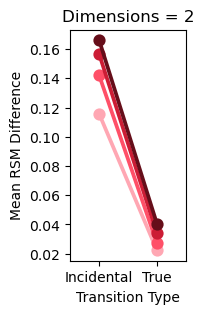

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 3))
sns.pointplot(
    data = diff_sums,
    x = 'transition',
    y = 'sum_corr_diff',
    order = ['incidental', 'true'],
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    ax = ax
)
ax.get_legend().remove()
ax.set_xticklabels(['Incidental', 'True'])
ax.set_xlabel('Transition Type')
ax.set_ylabel('Mean RSM Difference')
ax.set_title('Dimensions = 2')
set_axis_ratio(ax, 2) 
plt.tight_layout()
fig.savefig(f'{FIG_PATH}/rsm-differences.pdf')

# Training Curves

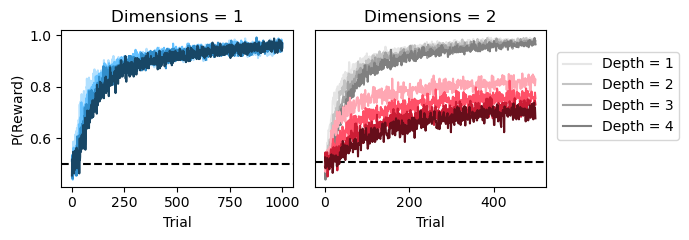

In [243]:
fig, axs = plt.subplots(1, 2, figsize=(7, 2.5))

### Dim = 1

axs[0].axhline(.5, c='k', ls='--')
idx = (training_df['dim'] == 1) & (training_df['trial'] < 1000)
sns.lineplot(
    data = training_df.loc[idx],
    x = 'trial',
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM1,
    errorbar = None,
    ax = axs[0]
)
axs[0].set_title('Dimensions = 1')
axs[0].set_xlabel('Trial')
axs[0].set_ylabel('P(Reward)')
axs[0].get_legend().remove()


### Dim = 2

axs[1].axhline(.5, c='k', ls='--')
idx = (
    (training_df['dim'] == 2) &
    (training_df['model_label'] == 'ff-biased') &
    (training_df['trial'] < 500)
)
sns.lineplot(
    data = training_df.loc[idx],
    x = 'trial',
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_BW,
    errorbar = None,
    ax = axs[1]
)
idx = (
    (training_df['dim'] == 2) &
    (training_df['model_label'] == 'ff') &
    (training_df['trial'] < 500)
)
sns.lineplot(
    data = training_df.loc[idx],
    x = 'trial',
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    errorbar = None,
    ax = axs[1]
)
axs[1].set_title('Dimensions = 2')
axs[1].set_xlabel('Trial')
axs[1].set_ylabel(None)
axs[1].set_yticks([])
handles = axs[1].get_legend_handles_labels()[0]
axs[1].legend(
    handles = handles[:4],
    labels = ['Depth = 1', 'Depth = 2', 'Depth = 3', 'Depth = 4'],
    loc = (1.05, .3)
)
fig.tight_layout()

fig.savefig(f'{FIG_PATH}/learning.pdf', dpi=300)

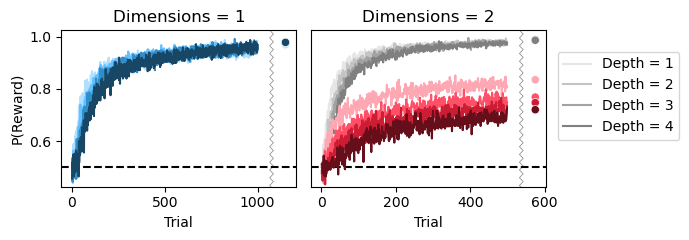

In [121]:
fig, axs = plt.subplots(1, 2, figsize=(7, 2.5))

### Dim = 1

axs[0].axhline(.5, c='k', ls='--')
idx = (training_df['dim'] == 1) & (training_df['trial'] < 1000)
sns.lineplot(
    data = training_df.loc[idx],
    x = 'trial',
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM1,
    errorbar = None,
    ax = axs[0]
)

# Final trial performance using Seaborn pointplot
idx = training_df['dim'] == 1
final_trial = np.max(training_df.loc[idx, 'trial'])
idx = idx & (training_df['trial'] > final_trial - 20)
final_trial_df = training_df.loc[idx, ['depth', 'trial', 'p_reward']]
final_trial_df['trial'] = 1200 - 50
final_trial_df = final_trial_df.groupby(['depth', 'trial']).mean().reset_index()
sns.scatterplot(
    data = final_trial_df,
    x = 'trial',  
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM1,
    ax = axs[0]
)



axs[0].set_title('Dimensions = 1')
axs[0].set_xlabel('Trial')
axs[0].set_ylabel('P(Reward)')
axs[0].get_legend().remove()


#axs[0].set_xticks([0, 300, 600, 900, 1200 - 25], ['0', '300', '600', '900', f'{final_trial - 20}-\n{final_trial}'])
axs[0].plot([1090 - 25, 1110 - 25]*24, np.linspace(.4, 1.1, 24*2), c='.5', lw=.5, zorder=0)
axs[0].set_ylim(.425, 1.025)




### Dim = 2

axs[1].axhline(.5, c='k', ls='--')
idx = (
    (training_df['dim'] == 2) &
    (training_df['model_label'] == 'ff-biased') &
    (training_df['trial'] < 500)
)
sns.lineplot(
    data = training_df.loc[idx],
    x = 'trial',
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_BW,
    errorbar = None,
    ax = axs[1]
)

# Final trial performance using Seaborn pointplot
idx = (
    (training_df['dim'] == 2) &
    (training_df['model_label'] == 'ff-biased') 
)
final_trial = np.max(training_df.loc[idx, 'trial'])
idx = idx & (training_df['trial'] > final_trial - 20)
final_trial_df = training_df.loc[idx, ['depth', 'trial', 'p_reward']]
final_trial_df['trial'] = 600 - 25
final_trial_df = final_trial_df.groupby(['depth', 'trial']).mean().reset_index()
sns.scatterplot(
    data = final_trial_df,
    x = 'trial',  
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_BW,
    ax = axs[1]
)


idx = (
    (training_df['dim'] == 2) &
    (training_df['model_label'] == 'ff') &
    (training_df['trial'] < 500)
)
sns.lineplot(
    data = training_df.loc[idx],
    x = 'trial',
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    errorbar = None,
    ax = axs[1]
)

# Final trial performance using Seaborn pointplot
idx = (
    (training_df['dim'] == 2) &
    (training_df['model_label'] == 'ff') 
)
final_trial = np.max(training_df.loc[idx, 'trial'])
idx = idx & (training_df['trial']  > final_trial - 20)
final_trial_df = training_df.loc[idx, ['depth', 'trial', 'p_reward']]
final_trial_df['trial'] = 600 - 25
final_trial_df = final_trial_df.groupby(['depth', 'trial']).mean().reset_index()
sns.scatterplot(
    data = final_trial_df,
    x = 'trial',  
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    ax = axs[1]
)


axs[1].set_title('Dimensions = 2')
axs[1].set_xlabel('Trial')
axs[1].set_ylabel(None)
axs[1].set_yticks([])
handles = axs[1].get_legend_handles_labels()[0]
axs[1].legend(
    handles = handles[:4],
    labels = ['Depth = 1', 'Depth = 2', 'Depth = 3', 'Depth = 4'],
    loc = (1.05, .3)
)

#axs[1].set_xticks([0, 150, 300, 450, 600 - 25/2], ['0', '150', '300', '450', f'{final_trial - 20}-\n{final_trial}'])
axs[1].plot([545 - 25/2, 555 - 25/2]*24, np.linspace(.4, 1.1, 24*2), c='.5', lw=.5, zorder=0)

axs[1].set_ylim(.425, 1.025)

fig.tight_layout()

#fig.savefig(f'{FIG_PATH}/convergence.pdf', dpi=300)

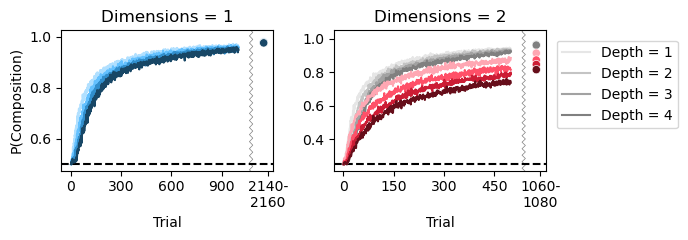

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(7, 2.5))

### Dim = 1

axs[0].axhline(.5, c='k', ls='--')
idx = (training_df['dim'] == 1) & (training_df['trial'] < 1000)
sns.lineplot(
    data = training_df.loc[idx],
    x = 'trial',
    y = 'p',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM1,
    errorbar = None,
    ax = axs[0]
)

# Final trial performance using Seaborn pointplot
idx = training_df['dim'] == 1
final_trial = np.max(training_df.loc[idx, 'trial'])
idx = idx & (training_df['trial'] > final_trial - 20)
final_trial_df = training_df.loc[idx, ['depth', 'trial', 'p']]
final_trial_df['trial'] = 1200 - 50
final_trial_df = final_trial_df.groupby(['depth', 'trial']).mean().reset_index()
sns.scatterplot(
    data = final_trial_df,
    x = 'trial',  
    y = 'p',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM1,
    ax = axs[0]
)



axs[0].set_title('Dimensions = 1')
axs[0].set_xlabel('Trial')
axs[0].set_ylabel('P(Composition)')
axs[0].get_legend().remove()


axs[0].set_xticks([0, 300, 600, 900, 1200 - 25], ['0', '300', '600', '900', f'{final_trial - 20}-\n{final_trial}'])
axs[0].plot([1090 - 25, 1110 - 25]*24, np.linspace(.45, 1.1, 24*2), c='.5', lw=.5, zorder=0)
axs[0].set_ylim(.475, 1.025)




### Dim = 2

axs[1].axhline(.25, c='k', ls='--')
idx = (
    (training_df['dim'] == 2) &
    (training_df['model_label'] == 'ff-biased') &
    (training_df['trial'] < 500)
)
sns.lineplot(
    data = training_df.loc[idx],
    x = 'trial',
    y = 'p',
    hue = 'depth',
    palette = DEPTH_PALETTE_BW,
    errorbar = None,
    ax = axs[1]
)

# Final trial performance using Seaborn pointplot
idx = (
    (training_df['dim'] == 2) &
    (training_df['model_label'] == 'ff-biased') 
)
final_trial = np.max(training_df.loc[idx, 'trial'])
idx = idx & (training_df['trial'] > final_trial - 20)
final_trial_df = training_df.loc[idx, ['depth', 'trial', 'p']]
final_trial_df['trial'] = 600 - 25
final_trial_df = final_trial_df.groupby(['depth', 'trial']).mean().reset_index()
sns.scatterplot(
    data = final_trial_df,
    x = 'trial',  
    y = 'p',
    hue = 'depth',
    palette = DEPTH_PALETTE_BW,
    ax = axs[1]
)


idx = (
    (training_df['dim'] == 2) &
    (training_df['model_label'] == 'ff') &
    (training_df['trial'] < 500)
)
sns.lineplot(
    data = training_df.loc[idx],
    x = 'trial',
    y = 'p',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    errorbar = None,
    ax = axs[1]
)

# Final trial performance using Seaborn pointplot
idx = (
    (training_df['dim'] == 2) &
    (training_df['model_label'] == 'ff') 
)
final_trial = np.max(training_df.loc[idx, 'trial'])
idx = idx & (training_df['trial']  > final_trial - 20)
final_trial_df = training_df.loc[idx, ['depth', 'trial', 'p']]
final_trial_df['trial'] = 600 - 25
final_trial_df = final_trial_df.groupby(['depth', 'trial']).mean().reset_index()
sns.scatterplot(
    data = final_trial_df,
    x = 'trial',  
    y = 'p',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    ax = axs[1]
)


axs[1].set_title('Dimensions = 2')
axs[1].set_xlabel('Trial')
axs[1].set_ylabel(None)
handles = axs[1].get_legend_handles_labels()[0]
axs[1].legend(
    handles = handles[:4],
    labels = ['Depth = 1', 'Depth = 2', 'Depth = 3', 'Depth = 4'],
    loc = (1.05, .3)
)

axs[1].set_xticks([0, 150, 300, 450, 600 - 25/2], ['0', '150', '300', '450', f'{final_trial - 20}-\n{final_trial}'])
axs[1].plot([545 - 25/2, 555 - 25/2]*24, np.linspace(.1875, 1.1, 24*2), c='.5', lw=.5, zorder=0)

axs[1].set_ylim(.2125, 1.05)

fig.tight_layout()

#fig.savefig(f'{FIG_PATH}/p-convergence.pdf', dpi=300)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_40547/3504955727.py:141: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(
/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_40547/3504955727.py:161: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(
/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_40547/3504955727.py:176: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(
/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_40547/3504955727.py:196: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(


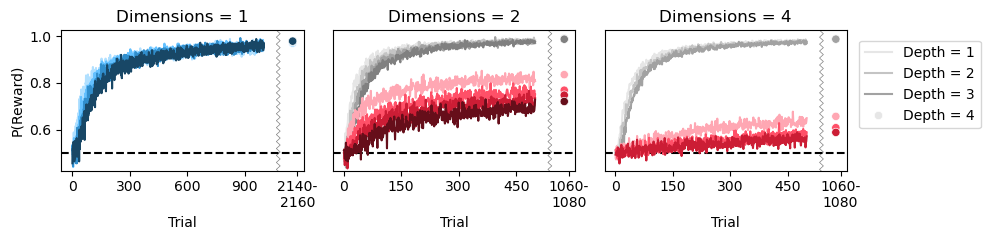

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(10, 2.5))

### Dim = 1

axs[0].axhline(.5, c='k', ls='--')
idx = (training_df['dim'] == 1) & (training_df['trial'] < 1000)
sns.lineplot(
    data = training_df.loc[idx],
    x = 'trial',
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM1,
    errorbar = None,
    ax = axs[0]
)

# Final trial performance using Seaborn pointplot
idx = training_df['dim'] == 1
final_trial = np.max(training_df.loc[idx, 'trial'])
idx = idx & (training_df['trial'] > final_trial - 20)
final_trial_df = training_df.loc[idx, ['depth', 'trial', 'p_reward']]
final_trial_df['trial'] = 1200 - 50
final_trial_df = final_trial_df.groupby(['depth', 'trial']).mean().reset_index()
sns.scatterplot(
    data = final_trial_df,
    x = 'trial',  
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM1,
    ax = axs[0]
)



axs[0].set_title('Dimensions = 1')
axs[0].set_xlabel('Trial')
axs[0].set_ylabel('P(Reward)')
axs[0].get_legend().remove()


axs[0].set_xticks([0, 300, 600, 900, 1200 - 25], ['0', '300', '600', '900', f'{final_trial - 20}-\n{final_trial}'])
axs[0].plot([1090 - 25, 1110 - 25]*24, np.linspace(.4, 1.1, 24*2), c='.5', lw=.5, zorder=0)
axs[0].set_ylim(.425, 1.025)




### Dim = 2

axs[1].axhline(.5, c='k', ls='--')
idx = (
    (training_df['dim'] == 2) &
    (training_df['model_label'] == 'ff-biased') &
    (training_df['trial'] < 500)
)
sns.lineplot(
    data = training_df.loc[idx],
    x = 'trial',
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_BW,
    errorbar = None,
    ax = axs[1]
)

# Final trial performance using Seaborn pointplot
idx = (
    (training_df['dim'] == 2) &
    (training_df['model_label'] == 'ff-biased') 
)
final_trial = np.max(training_df.loc[idx, 'trial'])
idx = idx & (training_df['trial'] > final_trial - 20)
final_trial_df = training_df.loc[idx, ['depth', 'trial', 'p_reward']]
final_trial_df['trial'] = 600 - 25
final_trial_df = final_trial_df.groupby(['depth', 'trial']).mean().reset_index()
sns.scatterplot(
    data = final_trial_df,
    x = 'trial',  
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_BW,
    ax = axs[1]
)


idx = (
    (training_df['dim'] == 2) &
    (training_df['model_label'] == 'ff') &
    (training_df['trial'] < 500)
)
sns.lineplot(
    data = training_df.loc[idx],
    x = 'trial',
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    errorbar = None,
    ax = axs[1]
)

# Final trial performance using Seaborn pointplot
idx = (
    (training_df['dim'] == 2) &
    (training_df['model_label'] == 'ff') 
)
final_trial = np.max(training_df.loc[idx, 'trial'])
idx = idx & (training_df['trial']  > final_trial - 20)
final_trial_df = training_df.loc[idx, ['depth', 'trial', 'p_reward']]
final_trial_df['trial'] = 600 - 25
final_trial_df = final_trial_df.groupby(['depth', 'trial']).mean().reset_index()
sns.scatterplot(
    data = final_trial_df,
    x = 'trial',  
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    ax = axs[1]
)


axs[1].set_title('Dimensions = 2')
axs[1].set_xlabel('Trial')
axs[1].set_ylabel(None)
axs[1].set_yticks([])
axs[1].get_legend().remove()
axs[1].set_xticks([0, 150, 300, 450, 600 - 25/2], ['0', '150', '300', '450', f'{final_trial - 20}-\n{final_trial}'])
axs[1].plot([545 - 25/2, 555 - 25/2]*24, np.linspace(.4, 1.1, 24*2), c='.5', lw=.5, zorder=0)

axs[1].set_ylim(.425, 1.025)



### Dim = 4

axs[2].axhline(.5, c='k', ls='--')
idx = (
    (training_df['dim'] == 4) &
    (training_df['model_label'] == 'ff-biased') &
    (training_df['trial'] < 500)
)
sns.lineplot(
    data = training_df.loc[idx],
    x = 'trial',
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_BW,
    errorbar = None,
    ax = axs[2]
)

# Final trial performance using Seaborn pointplot
idx = (
    (training_df['dim'] == 4) &
    (training_df['model_label'] == 'ff-biased') 
)
final_trial = np.max(training_df.loc[idx, 'trial'])
idx = idx & (training_df['trial'] > final_trial - 20)
final_trial_df = training_df.loc[idx, ['depth', 'trial', 'p_reward']]
final_trial_df['trial'] = 600 - 25
final_trial_df = final_trial_df.groupby(['depth', 'trial']).mean().reset_index()
sns.scatterplot(
    data = final_trial_df,
    x = 'trial',  
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_BW,
    ax = axs[2]
)


idx = (
    (training_df['dim'] == 4) &
    (training_df['model_label'] == 'ff') &
    (training_df['trial'] < 500)
)
sns.lineplot(
    data = training_df.loc[idx],
    x = 'trial',
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    errorbar = None,
    ax = axs[2]
)

# Final trial performance using Seaborn pointplot
idx = (
    (training_df['dim'] == 4) &
    (training_df['model_label'] == 'ff') 
)
final_trial = np.max(training_df.loc[idx, 'trial'])
idx = idx & (training_df['trial']  > final_trial - 20)
final_trial_df = training_df.loc[idx, ['depth', 'trial', 'p_reward']]
final_trial_df['trial'] = 600 - 25
final_trial_df = final_trial_df.groupby(['depth', 'trial']).mean().reset_index()
sns.scatterplot(
    data = final_trial_df,
    x = 'trial',  
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    ax = axs[2]
)


axs[2].set_title('Dimensions = 4')
axs[2].set_xlabel('Trial')
axs[2].set_ylabel(None)
axs[2].set_yticks([])
handles = axs[2].get_legend_handles_labels()[0]
axs[2].legend(
    handles = handles[:4],
    labels = ['Depth = 1', 'Depth = 2', 'Depth = 3', 'Depth = 4'],
    loc = (1.05, .3)
)

axs[2].set_xticks([0, 150, 300, 450, 600 - 25/2], ['0', '150', '300', '450', f'{final_trial - 20}-\n{final_trial}'])
axs[2].plot([545 - 25/2, 555 - 25/2]*24, np.linspace(.4, 1.1, 24*2), c='.5', lw=.5, zorder=0)

axs[2].set_ylim(.425, 1.025)

fig.tight_layout()

#fig.savefig(f'{FIG_PATH}/convergence.pdf', dpi=300)



# Characterizing learned representations

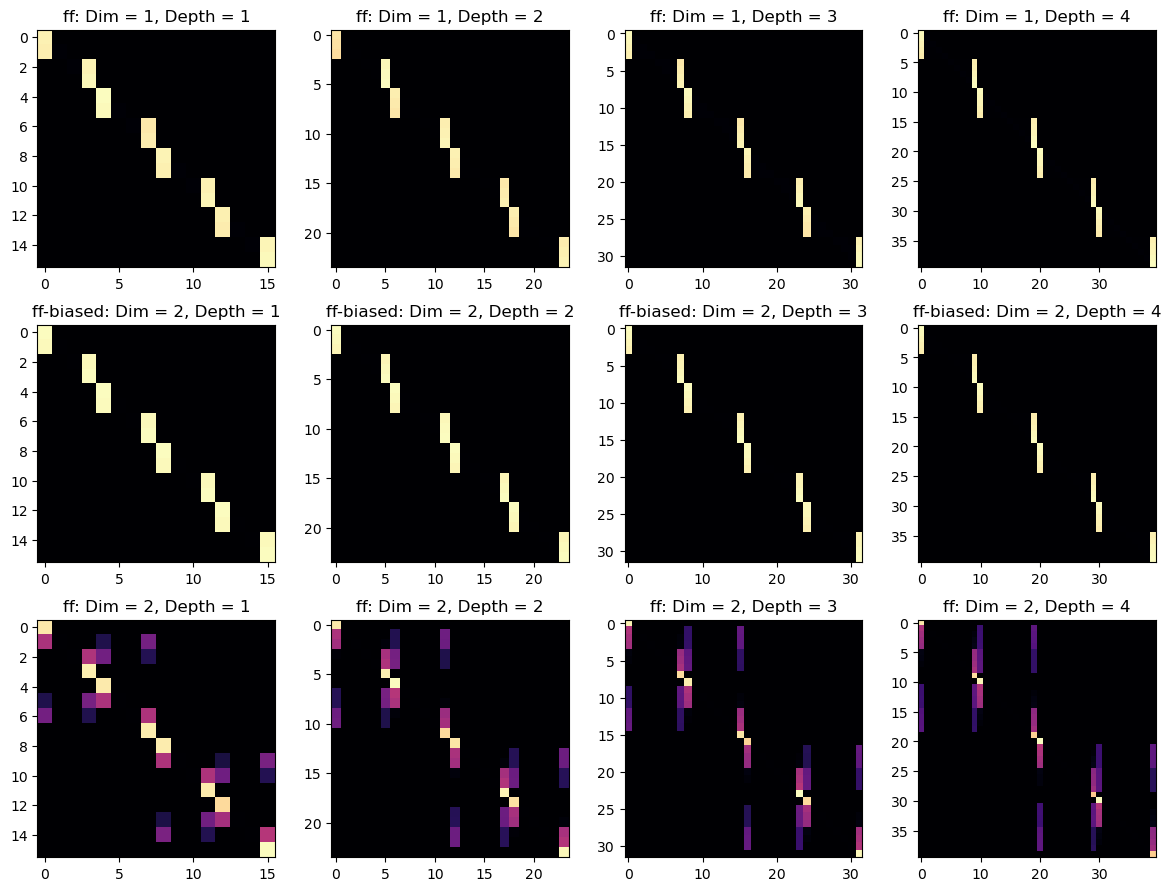

In [97]:
n_subplots = len(mean_representations.keys())
n_cols = 4
n_rows = int(np.ceil(n_subplots/n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
i = 0
for dim in [1, 2]:
    for model_label in ['ff-biased', 'ff']:
        if dim == 1 and model_label == 'ff-biased':
            continue
        for j, depth in enumerate([1, 2, 3, 4]):
            ax = axs[i, j]
            ax.imshow(
                mean_representations[(dim, depth, model_label)],
                cmap='magma'
            )
            ax.set_title(f'{model_label}: Dim = {dim}, Depth = {depth}')
        i += 1
fig.tight_layout()

            

In [ ]:

information_counts_df = []
for key in representations.keys():
    n_features = len(representations[key])
    true_mask = create_mask(n_features)
    inci_mask = (1 - true_mask - np.eye(len(true_mask)))
    try:
        information_counts_df.append({
            'dim': key[0],
            'depth': key[1],
            'model_label': key[2],
            'id': key[3],
            'true': np.sum(representations[key]*true_mask),
            'incidental': np.sum(representations[key]*inci_mask)
        })
    except:
        print(f'Wrong shape for {key}')

information_counts_df = pd.DataFrame(information_counts_df)

information_counts_df = pd.merge(
    information_counts_df,
    subj_df,
    on = ['model_label', 'id']
)


information_counts_df['total'] = information_counts_df['true'] + information_counts_df['incidental']
information_counts_df['p_incidental'] = information_counts_df['incidental']/information_counts_df['total']
information_counts_df['true_norm'] = information_counts_df['true']/information_counts_df['depth']
information_counts_df['incidental_norm'] = information_counts_df['incidental']/information_counts_df['depth']
information_counts_df['true_norm'] = information_counts_df['true_norm']/information_counts_df['alpha']
information_counts_df['incidental_norm'] = information_counts_df['incidental_norm']/information_counts_df['alpha']


information_counts_df

Wrong shape for (1, 4, 'ff', 242)
Wrong shape for (1, 4, 'ff', 241)
Wrong shape for (1, 4, 'ff', 190)
Wrong shape for (1, 4, 'ff', 170)
Wrong shape for (1, 4, 'ff', 210)
Wrong shape for (1, 2, 'ff', 121)
Wrong shape for (1, 2, 'ff', 64)
Wrong shape for (1, 2, 'ff', 150)
Wrong shape for (1, 2, 'ff', 224)
Wrong shape for (1, 2, 'ff', 228)
Wrong shape for (1, 2, 'ff', 21)
Wrong shape for (1, 2, 'ff', 239)
Wrong shape for (1, 2, 'ff', 33)
Wrong shape for (1, 1, 'ff', 134)
Wrong shape for (1, 1, 'ff', 88)
Wrong shape for (1, 1, 'ff', 250)
Wrong shape for (1, 1, 'ff', 133)
Wrong shape for (1, 1, 'ff', 119)
Wrong shape for (1, 1, 'ff', 247)
Wrong shape for (1, 1, 'ff', 209)
Wrong shape for (1, 1, 'ff', 169)
Wrong shape for (1, 1, 'ff', 10)
Wrong shape for (1, 1, 'ff', 38)
Wrong shape for (1, 1, 'ff', 150)
Wrong shape for (1, 1, 'ff', 146)
Wrong shape for (1, 1, 'ff', 219)
Wrong shape for (1, 1, 'ff', 225)
Wrong shape for (1, 1, 'ff', 190)
Wrong shape for (1, 1, 'ff', 19)
Wrong shape for (1, 1

,dim,depth,model_label,id,true,incidental,segmentation,alpha,total,p_incidental,true_norm,incidental_norm
0,2,4,ff,108,2025.280716,2037.696095,0,0.188006,4062.976811,0.501528,2693.107951,2709.617246
1,2,4,ff,120,4131.396490,4131.396490,0,0.960045,8262.792979,0.500000,1075.833531,1075.833531
2,2,4,ff,134,3277.499810,3277.499810,0,0.762384,6554.999620,0.500000,1074.753302,1074.753302
3,2,4,ff,2,32.096215,32.120911,0,0.010941,64.217126,0.500192,733.398420,733.962724
4,2,4,ff,49,1845.610994,1845.569402,0,0.430851,3691.180396,0.499994,1070.910432,1070.886298
...,...,...,...,...,...,...,...,...,...,...,...,...
1959,1,3,ff,44,4301.971056,2118.111649,0,0.993994,6420.082705,0.329920,1442.654583,710.303123
1960,1,3,ff,50,839.927528,0.000000,0,0.133322,839.927528,0.000000,2099.994967,0.000000
1961,1,3,ff,139,1483.180915,0.000000,0,0.232590,1483.180915,0.000000,2125.604660,0.000000
1962,1,3,ff,111,3200.781897,0.000000,0,0.497652,3200.781897,0.000000,2143.924494,0.000000


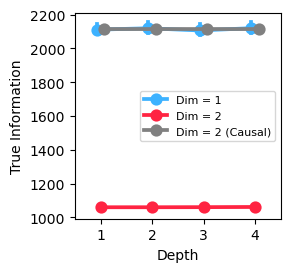

In [15]:
# Label the three groups of data
idx = information_counts_df['dim'] == 1
information_counts_df.loc[idx, 'label'] = 'dim1'
idx = (
    (information_counts_df['dim'] == 2) &
    (information_counts_df['model_label'] == 'ff') 
)
information_counts_df.loc[idx, 'label'] = 'dim2_ff'
idx = (
    (information_counts_df['dim'] == 2) &
    (information_counts_df['model_label'] == 'ff-biased') 
)
information_counts_df.loc[idx, 'label'] = 'dim2_ff-biased'


fig, ax = plt.subplots(figsize=(3, 3))

sns.pointplot(
    data = information_counts_df,
    x = 'depth',
    y = 'true_norm',
    hue = 'label',
    hue_order = ['dim1', 'dim2_ff', 'dim2_ff-biased'],
    palette = LABEL_PALETTE,
    dodge = .15,
    ax = ax
)
ax.set_ylabel('True Information')
ax.set_xlabel('Depth')
handles = ax.get_legend_handles_labels()[0]
ax.legend(
    handles = handles,
    labels = ['Dim = 1', 'Dim = 2', 'Dim = 2 (Causal)'],
    fontsize = 8
)
set_axis_ratio(ax)

fig.tight_layout()

#fig.savefig(f'{FIG_PATH}/true-comparison.pdf', dpi=300)


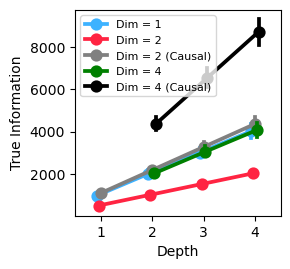

In [23]:
# Label the three groups of data
idx = information_counts_df['dim'] == 1
information_counts_df.loc[idx, 'label'] = 'dim1'
idx = (
    (information_counts_df['dim'] == 2) &
    (information_counts_df['model_label'] == 'ff') 
)
information_counts_df.loc[idx, 'label'] = 'dim2_ff'
idx = (
    (information_counts_df['dim'] == 2) &
    (information_counts_df['model_label'] == 'ff-biased') 
)
information_counts_df.loc[idx, 'label'] = 'dim2_ff-biased'
idx = (
    (information_counts_df['dim'] == 4) &
    (information_counts_df['model_label'] == 'ff') 
)
information_counts_df.loc[idx, 'label'] = 'dim4_ff'
idx = (
    (information_counts_df['dim'] == 4) &
    (information_counts_df['model_label'] == 'ff-biased') 
)
information_counts_df.loc[idx, 'label'] = 'dim4_ff-biased'


fig, ax = plt.subplots(figsize=(3, 3))

LABEL_PALETTE['dim4_ff'] = 'green'
LABEL_PALETTE['dim4_ff-biased'] = 'black'

sns.pointplot(
    data = information_counts_df,
    x = 'depth',
    y = 'true',
    hue = 'label',
    hue_order = ['dim1', 'dim2_ff', 'dim2_ff-biased', 'dim4_ff', 'dim4_ff-biased'],
    palette = LABEL_PALETTE,
    dodge = .15,
    ax = ax
)
ax.set_ylabel('True Information')
ax.set_xlabel('Depth')
handles = ax.get_legend_handles_labels()[0]
ax.legend(
    handles = handles,
    labels = ['Dim = 1', 'Dim = 2', 'Dim = 2 (Causal)', 'Dim = 4', 'Dim = 4 (Causal)'],
    fontsize = 8
)
set_axis_ratio(ax)

fig.tight_layout()

#fig.savefig(f'{FIG_PATH}/true-comparison.pdf', dpi=300)


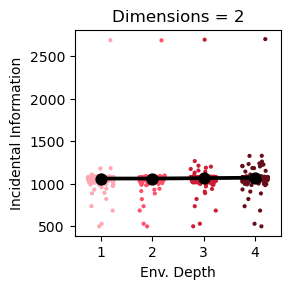

In [156]:
fig, ax = plt.subplots(figsize=(3, 3))
idx = (
    (information_counts_df['dim'] == 2) &
    (information_counts_df['model_label'] == 'ff')
)
sns.stripplot(
    data = information_counts_df.loc[idx],
    x = 'depth',
    y = 'incidental_norm',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    zorder = 0,
    s = 3, 
    jitter = .25,
    ax = ax
    
)
sns.pointplot(
    data = information_counts_df.loc[idx],
    x = 'depth',
    y = 'incidental_norm',
    color = 'k',
    ax = ax
)
ax.set_title('Dimensions = 2')
ax.set_xlabel('Env. Depth')
ax.set_ylabel('Incidental Information')
ax.get_legend().remove()
set_axis_ratio(ax)
fig.tight_layout()

#fig.savefig(f'{FIG_PATH}/incidental.pdf', dpi=300)

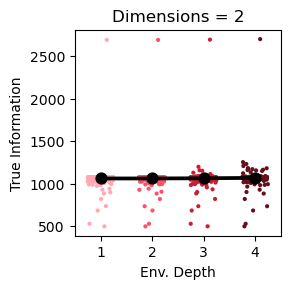

In [157]:
fig, ax = plt.subplots(figsize=(3, 3))
idx = (
    (information_counts_df['dim'] == 2) &
    (information_counts_df['model_label'] == 'ff')
)
sns.stripplot(
    data = information_counts_df.loc[idx],
    x = 'depth',
    y = 'true_norm',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    zorder = 0,
    s = 3, 
    jitter = .25,
    ax = ax
    
)
sns.pointplot(
    data = information_counts_df.loc[idx],
    x = 'depth',
    y = 'true_norm',
    color = 'k',
    ax = ax
)
ax.set_title('Dimensions = 2')
ax.set_xlabel('Env. Depth')
ax.set_ylabel('True Information')
ax.get_legend().remove()
set_axis_ratio(ax)
fig.tight_layout()

#fig.savefig(f'{FIG_PATH}/true.pdf', dpi=300)

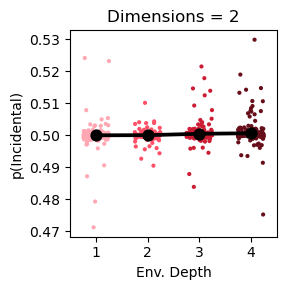

In [160]:
fig, ax = plt.subplots(figsize=(3, 3))
idx = (
    (information_counts_df['dim'] == 2) &
    (information_counts_df['model_label'] == 'ff')
)
sns.stripplot(
    data = information_counts_df.loc[idx],
    x = 'depth',
    y = 'p_incidental',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    zorder = 0,
    s = 3, 
    jitter = .25,
    ax = ax
    
)
sns.pointplot(
    data = information_counts_df.loc[idx],
    x = 'depth',
    y = 'p_incidental',
    color = 'k',
    ax = ax
)
ax.set_title('Dimensions = 2')
ax.set_xlabel('Env. Depth')
ax.set_ylabel('p(Incidental)')
ax.get_legend().remove()
set_axis_ratio(ax)
fig.tight_layout()

fig.savefig(f'{FIG_PATH}/p-incidental.pdf', dpi=300)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_40547/608069386.py:6: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.stripplot(


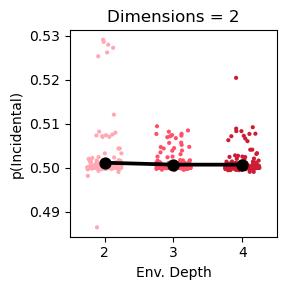

In [24]:
fig, ax = plt.subplots(figsize=(3, 3))
idx = (
    (information_counts_df['dim'] == 4) &
    (information_counts_df['model_label'] == 'ff')
)
sns.stripplot(
    data = information_counts_df.loc[idx],
    x = 'depth',
    y = 'p_incidental',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    zorder = 0,
    s = 3, 
    jitter = .25,
    ax = ax
    
)
sns.pointplot(
    data = information_counts_df.loc[idx],
    x = 'depth',
    y = 'p_incidental',
    color = 'k',
    ax = ax
)
ax.set_title('Dimensions = 2')
ax.set_xlabel('Env. Depth')
ax.set_ylabel('p(Incidental)')
ax.get_legend().remove()
set_axis_ratio(ax)
fig.tight_layout()

#fig.savefig(f'{FIG_PATH}/p-incidental.pdf', dpi=300)

# Characterizing Inference

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_80893/3530913590.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Infreq.', 'Freq.'])


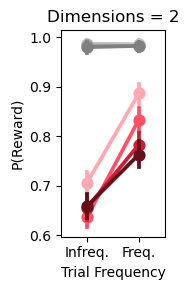

In [32]:
fig, ax = plt.subplots(figsize=(2.5, 3))

# Plot Dim 2 with incidental learning
idx = (
    (test_summary['dim'] == 2) &
    (test_summary['model_label'] == 'ff') &
    (test_summary['old'] == 1)
)
sns.pointplot(
    data = test_summary.loc[idx],
    x = 'freq_target',
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    ax = ax
)

# Plot Dim 2 no incidental learning
idx = (
    (test_summary['dim'] == 2) &
    (test_summary['model_label'] == 'ff-biased') &
    (test_summary['old'] == 1)
)
sns.pointplot(
    data = test_summary.loc[idx],
    x = 'freq_target',
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_BW,
    zorder = 0,
    ax = ax
)

ax.set_title('Dimensions = 2')
ax.set_xlabel('Trial Frequency')
ax.set_ylabel('P(Reward)')
ax.set_xticklabels(['Infreq.', 'Freq.'])
ax.get_legend().remove()
#handles = ax.get_legend_handles_labels()[0]
#ax.legend(
#    handles = handles[:4],
#    labels = ['Depth = 1', 'Depth = 2', 'Depth = 3', 'Depth = 4'],
#    loc = (1.05, .7)
#)

set_axis_ratio(ax, 2)
fig.tight_layout()

fig.savefig(f'{FIG_PATH}/test-freq-dim2.pdf', dpi=300)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_80893/3531400742.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Old', 'Novel'])


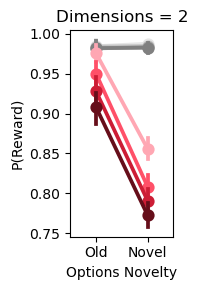

In [29]:
fig, ax = plt.subplots(figsize=(2.5, 3))

# Plot Dim 2 with incidental learning
idx = (
    (test_summary['dim'] == 2) &
    (test_summary['model_label'] == 'ff') &
    (test_summary['p_true'] == .5) &
    (test_summary['p_incidental'] == .5) 
)
sns.pointplot(
    data = test_summary.loc[idx],
    x = 'novel_options',
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_DIM2,
    ax = ax
)

# Plot Dim 2 no incidental learning
idx = (
    (test_summary['dim'] == 2) &
    (test_summary['model_label'] == 'ff-biased') &
    (test_summary['p_true'] == .5) &
    (test_summary['p_incidental'] == .5) 
)
sns.pointplot(
    data = test_summary.loc[idx],
    x = 'novel_options',
    y = 'p_reward',
    hue = 'depth',
    palette = DEPTH_PALETTE_BW,
    zorder = 0,
    ax = ax
)

ax.set_title('Dimensions = 2')
ax.set_xlabel('Options Novelty')
ax.set_ylabel('P(Reward)')
ax.set_xticklabels(['Old', 'Novel'])
ax.get_legend().remove()
#handles = ax.get_legend_handles_labels()[0]
#ax.legend(
#    handles = handles[:4],
#    labels = ['Depth = 1', 'Depth = 2', 'Depth = 3', 'Depth = 4'],
#    loc = (1.05, .7)
#)

set_axis_ratio(ax, 2)
fig.tight_layout()

fig.savefig(f'{FIG_PATH}/test-opsnov-dim2.pdf', dpi=300)